<a href="https://colab.research.google.com/github/Laaliji/Movies_Recommandation_System/blob/main/Clustering_movielens_100k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurations

In [49]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2463304 sha256=f04d38a2afd39136cecbf2e3731b67139dd1fee4aa1f4da779486bd983943753
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [53]:
!pip install "numpy<2.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 42.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
directory_path = '/content/drive/MyDrive/movies kaggle'
files_in_directory = os.listdir(directory_path)
print(files_in_directory)

['u.info', 'u.genre', 'u.data', 'u4.base', 'u4.test', 'mku.sh', 'allbut.pl', 'u.item', 'ua.base', 'README', 'u3.base', 'u2.base', 'u3.test', 'u1.base', 'u2.test', 'u.user', 'u5.base', 'u5.test', 'u1.test', 'u.occupation', 'ub.test', 'ub.base', 'ua.test']


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Exploratory Data Analysis (EDA)

In [6]:
# 1. Load u.data (ratings)
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings_df = pd.read_csv(os.path.join(directory_path, 'u.data'), sep='\t', names=ratings_cols)

# 2. Load u.item (movies)
# Note: u.item uses | separator and has many columns (movie ID, title, release date, etc.)
item_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url'] + [f'genre_{i}' for i in range(19)]
items_df = pd.read_csv(os.path.join(directory_path, 'u.item'), sep='|', names=item_cols, encoding='latin-1')

# 3. Load u.user (users)
user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users_df = pd.read_csv(os.path.join(directory_path, 'u.user'), sep='|', names=user_cols)

# 4. Load u.genre (genres)
genre_cols = ['genre', 'genre_id']
genres_df = pd.read_csv(os.path.join(directory_path, 'u.genre'), sep='|', names=genre_cols)

# 5. Load u.occupation
occupations_df = pd.read_csv(os.path.join(directory_path, 'u.occupation'), names=['occupation'])

In [7]:
# --- Basic Inspection ---
print("=== Ratings Data (u.data) ===")
print(ratings_df.head())
print("\nShape:", ratings_df.shape)
print("\nMissing Values:\n", ratings_df.isnull().sum())
print("\nRating Statistics:\n", ratings_df['rating'].describe())

=== Ratings Data (u.data) ===
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596

Shape: (100000, 4)

Missing Values:
 user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

Rating Statistics:
 count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


In [8]:
print("\n=== Movies Data (u.item) ===")
print(items_df[['movie_id', 'title', 'release_date']].head())
print("\nShape:", items_df.shape)
print("\nMissing Values:\n", items_df.isnull().sum())


=== Movies Data (u.item) ===
   movie_id              title release_date
0         1   Toy Story (1995)  01-Jan-1995
1         2   GoldenEye (1995)  01-Jan-1995
2         3  Four Rooms (1995)  01-Jan-1995
3         4  Get Shorty (1995)  01-Jan-1995
4         5     Copycat (1995)  01-Jan-1995

Shape: (1682, 24)

Missing Values:
 movie_id                 0
title                    0
release_date             1
video_release_date    1682
imdb_url                 3
genre_0                  0
genre_1                  0
genre_2                  0
genre_3                  0
genre_4                  0
genre_5                  0
genre_6                  0
genre_7                  0
genre_8                  0
genre_9                  0
genre_10                 0
genre_11                 0
genre_12                 0
genre_13                 0
genre_14                 0
genre_15                 0
genre_16                 0
genre_17                 0
genre_18                 0
dtype: int64


1,682 movies with metadata (title, release date, genres, etc.). Missing values: `release_date` (1), `video_release_date` (1,682), `imdb_url` (3).

In [9]:
print("\n=== Users Data (u.user) ===")
print(users_df.head())
print("\nShape:", users_df.shape)
print("\nMissing Values:\n", users_df.isnull().sum())


=== Users Data (u.user) ===
   user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213

Shape: (943, 5)

Missing Values:
 user_id       0
age           0
gender        0
occupation    0
zip_code      0
dtype: int64


In [10]:
print("\n=== Genres Data (u.genre) ===")
print(genres_df)
print("\nShape:", genres_df.shape)


=== Genres Data (u.genre) ===
          genre  genre_id
0       unknown         0
1        Action         1
2     Adventure         2
3     Animation         3
4    Children's         4
5        Comedy         5
6         Crime         6
7   Documentary         7
8         Drama         8
9       Fantasy         9
10    Film-Noir        10
11       Horror        11
12      Musical        12
13      Mystery        13
14      Romance        14
15       Sci-Fi        15
16     Thriller        16
17          War        17
18      Western        18

Shape: (19, 2)


In [11]:
print("\n=== Occupations Data (u.occupation) ===")
print(occupations_df)
print("\nShape:", occupations_df.shape)


=== Occupations Data (u.occupation) ===
       occupation
0   administrator
1          artist
2          doctor
3        educator
4        engineer
5   entertainment
6       executive
7      healthcare
8       homemaker
9          lawyer
10      librarian
11      marketing
12           none
13          other
14     programmer
15        retired
16       salesman
17      scientist
18        student
19     technician
20         writer

Shape: (21, 1)


In [12]:
# --- EDA: Key Insights ---
# 1. Rating Distribution
print("\n=== Rating Distribution ===")
rating_counts = ratings_df['rating'].value_counts().sort_index()
print(rating_counts)


=== Rating Distribution ===
rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64


In [13]:
# 2. Number of Users and Movies
n_users = ratings_df['user_id'].nunique()
n_movies = ratings_df['movie_id'].nunique()
print(f"\nNumber of unique users: {n_users}")
print(f"Number of unique movies: {n_movies}")


Number of unique users: 943
Number of unique movies: 1682


* 943 unique users and 1,682 unique movies.
* **Interpretation:** The dataset is relatively sparse. With 100,000 ratings, the average user rates ~106 movies (100,000 / 943), and the average movie receives ~59 ratings (100,000 / 1,682). However, the sparsity is evident: 943 users × 1,682 movies = 1,586,126 possible ratings, so only ~6.3% (100,000 / 1,586,126) of the user-movie matrix is filled. This sparsity is typical in recommendation systems and suggests that collaborative filtering may need techniques like matrix factorization to handle missing data.

In [14]:
# 3. Most-Rated Movies
print("\n=== Top 5 Most-Rated Movies ===")
most_rated = ratings_df.groupby('movie_id').size().sort_values(ascending=False).head()
most_rated_titles = most_rated.reset_index().merge(items_df[['movie_id', 'title']], on='movie_id')
most_rated_titles.columns = ['movie_id', 'rating_count', 'title']
print(most_rated_titles)


=== Top 5 Most-Rated Movies ===
   movie_id  rating_count                      title
0        50           583           Star Wars (1977)
1       258           509             Contact (1997)
2       100           508               Fargo (1996)
3       181           507  Return of the Jedi (1983)
4       294           485           Liar Liar (1997)


* "Star Wars (1977)" (583 ratings), "Contact (1997)" (509), "Fargo (1996)" (508), "Return of the Jedi (1983)" (507), "Liar Liar (1997)" (485).
* **Interpretation:** Popular movies are a mix of classics ("Star Wars", "Return of the Jedi") and recent hits ("Contact", "Liar Liar"), aligning with the release year distribution (1990s dominance). These movies likely appeal to a broad audience, contributing to their high rating counts.

In [15]:
# 4. Average Ratings per Movie
print("\n=== Top 5 Movies by Average Rating (min 50 ratings) ===")
avg_ratings = ratings_df.groupby('movie_id')['rating'].agg(['mean', 'count'])
avg_ratings = avg_ratings[avg_ratings['count'] >= 50].sort_values('mean', ascending=False).head()
avg_ratings_titles = avg_ratings.reset_index().merge(items_df[['movie_id', 'title']], on='movie_id')
print(avg_ratings_titles[['movie_id', 'title', 'mean', 'count']])


=== Top 5 Movies by Average Rating (min 50 ratings) ===
   movie_id                                              title      mean  \
0       408                              Close Shave, A (1995)  4.491071   
1       318                            Schindler's List (1993)  4.466443   
2       169                         Wrong Trousers, The (1993)  4.466102   
3       483                                  Casablanca (1942)  4.456790   
4       114  Wallace & Gromit: The Best of Aardman Animatio...  4.447761   

   count  
0    112  
1    298  
2    118  
3    243  
4     67  


* **Interpretation:** High-rated movies include critically acclaimed films ("Schindler's List", "Casablanca") and niche animations ("Close Shave", "Wrong Trousers"). The minimum 50-rating threshold ensures reliability, but these movies have fewer ratings than the most-rated ones, suggesting they may appeal to a smaller but more appreciative audience. This balance between popularity and quality is useful for recommendation systems—users may prefer highly rated niche films over popular but average ones.

In [16]:
# 5. User Demographics: Age
print("\n=== User Age Statistics ===")
print(users_df['age'].describe())


=== User Age Statistics ===
count    943.000000
mean      34.051962
std       12.192740
min        7.000000
25%       25.000000
50%       31.000000
75%       43.000000
max       73.000000
Name: age, dtype: float64


In [17]:
# 6. User Demographics: Gender
print("\n=== User Gender Distribution ===")
print(users_df['gender'].value_counts())


=== User Gender Distribution ===
gender
M    670
F    273
Name: count, dtype: int64


In [18]:
# 7. User Demographics: Occupation
print("\n=== User Occupation Distribution ===")
print(users_df['occupation'].value_counts())


=== User Occupation Distribution ===
occupation
student          196
other            105
educator          95
administrator     79
engineer          67
programmer        66
librarian         51
writer            45
executive         32
scientist         31
artist            28
technician        27
marketing         26
entertainment     18
healthcare        16
retired           14
lawyer            12
salesman          12
none               9
homemaker          7
doctor             7
Name: count, dtype: int64


In [19]:
# 8. Genre Analysis
genre_columns = [col for col in items_df.columns if col.startswith('genre_')]
genres_count = items_df[genre_columns].sum()
genres_count.index = genres_df['genre'].values[:len(genre_columns)]  # Map genre IDs to names
print("\n=== Number of Movies per Genre ===")
print(genres_count.sort_values(ascending=False))


=== Number of Movies per Genre ===
Drama          725
Comedy         505
Action         251
Thriller       251
Romance        247
Adventure      135
Children's     122
Crime          109
Sci-Fi         101
Horror          92
War             71
Mystery         61
Musical         56
Documentary     50
Animation       42
Western         27
Film-Noir       24
Fantasy         22
unknown          2
dtype: int64


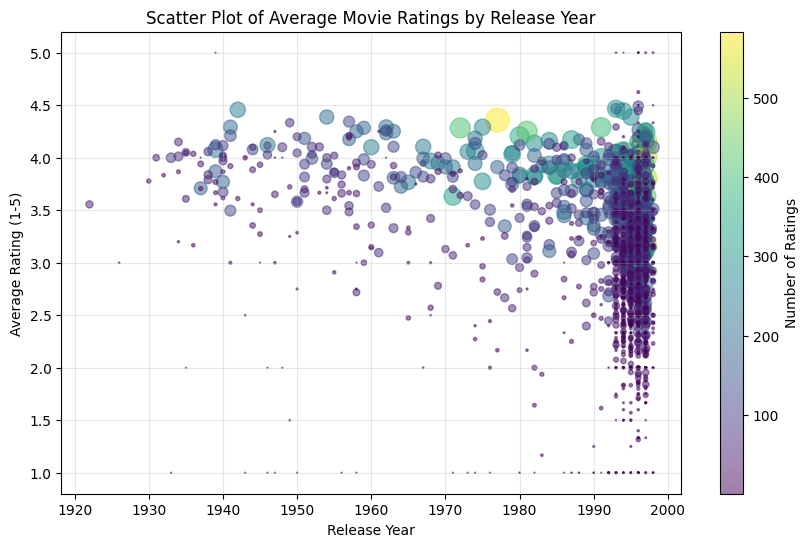

=== Plot 1: Ratings vs. Release Year Summary ===
Total movies with release year: 1681
Year range: 1922 to 1998
Average rating range: 1.00 to 5.00
Number of ratings range: 1 to 583


In [21]:
# --- Plot 1: Ratings vs. Movie Release Year ---
# Extract release year from release_date
items_df['release_year'] = pd.to_datetime(items_df['release_date'], errors='coerce').dt.year
movie_stats = ratings_df.groupby('movie_id')['rating'].agg(['mean', 'count']).reset_index()
movie_stats = movie_stats.merge(items_df[['movie_id', 'title', 'release_year']], on='movie_id')
movie_stats = movie_stats.dropna(subset=['release_year'])  # Drop movies with missing release years

plt.figure(figsize=(10, 6))
plt.scatter(
    movie_stats['release_year'],
    movie_stats['mean'],
    s=movie_stats['count'] * 0.5,  # Scale point size by rating count
    alpha=0.5,
    c=movie_stats['count'],
    cmap='viridis'
)
plt.colorbar(label='Number of Ratings')
plt.xlabel('Release Year')
plt.ylabel('Average Rating (1-5)')
plt.title('Scatter Plot of Average Movie Ratings by Release Year')
plt.grid(True, alpha=0.3)
plt.show()

print("=== Plot 1: Ratings vs. Release Year Summary ===")
print(f"Total movies with release year: {len(movie_stats)}")
print(f"Year range: {movie_stats['release_year'].min():.0f} to {movie_stats['release_year'].max():.0f}")
print(f"Average rating range: {movie_stats['mean'].min():.2f} to {movie_stats['mean'].max():.2f}")
print(f"Number of ratings range: {movie_stats['count'].min()} to {movie_stats['count'].max()}")

* Scatter Plot (Ratings vs. Release Year): The scatter plot shows that most movies are from the 1980s–1998, with average ratings mostly between 2.5 and 4.5. Popular movies (larger points, up to 583 ratings) tend to be from the 1990s, with some outliers (e.g., a 1977 movie with ~583 ratings, likely "Star Wars").
* **Interpretation:** The dataset is biased toward newer movies (1980s–1990s), reflecting the dataset’s collection period (1998). Older movies (pre-1960) are sparse, likely due to limited availability or user interest at the time. The scatter plot suggests that popular movies (e.g., "Star Wars", 1977) have high ratings and many votes, but there’s no clear trend of ratings improving or worsening over time—average ratings are fairly consistent across decades, though newer movies have more ratings.

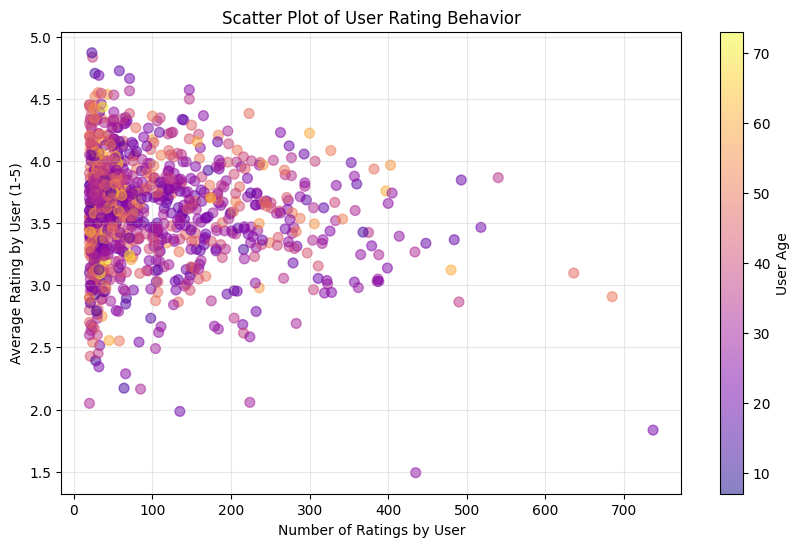


=== Plot 2: User Rating Count vs. Average Rating Summary ===
Total users: 943
Rating count range: 20 to 737
Average rating range: 1.49 to 4.87
Age range: 7 to 73


In [22]:
# --- Plot 2: User Rating Count vs. Average Rating ---
user_stats = ratings_df.groupby('user_id')['rating'].agg(['mean', 'count']).reset_index()
user_stats = user_stats.merge(users_df[['user_id', 'age']], on='user_id')

plt.figure(figsize=(10, 6))
plt.scatter(
    user_stats['count'],
    user_stats['mean'],
    s=50,
    alpha=0.5,
    c=user_stats['age'],
    cmap='plasma'
)
plt.colorbar(label='User Age')
plt.xlabel('Number of Ratings by User')
plt.ylabel('Average Rating by User (1-5)')
plt.title('Scatter Plot of User Rating Behavior')
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== Plot 2: User Rating Count vs. Average Rating Summary ===")
print(f"Total users: {len(user_stats)}")
print(f"Rating count range: {user_stats['count'].min()} to {user_stats['count'].max()}")
print(f"Average rating range: {user_stats['mean'].min():.2f} to {user_stats['mean'].max():.2f}")
print(f"Age range: {user_stats['age'].min()} to {user_stats['age'].max()}")

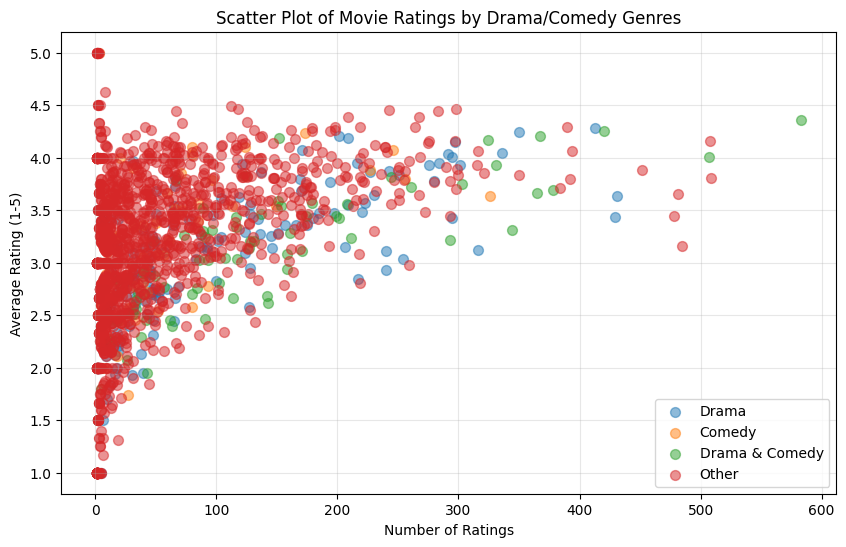


=== Plot 3: Genre-Based Ratings Summary ===
genre
Other             1371
Drama              176
Drama & Comedy      75
Comedy              60
Name: count, dtype: int64
Average rating by genre:
genre
Comedy            3.199430
Drama             2.909543
Drama & Comedy    3.099598
Other             3.090731
Name: mean, dtype: float64
Number of ratings by genre:
genre
Comedy             3448
Drama             15284
Drama & Comedy    10305
Other             70963
Name: count, dtype: int64


In [23]:
# --- Plot 3: Genre-Based Ratings (Drama vs. Comedy) ---
# Identify Drama and Comedy genres (based on u.genre, Drama is genre_1, Comedy is genre_2)
movie_stats = ratings_df.groupby('movie_id')['rating'].agg(['mean', 'count']).reset_index()
movie_stats = movie_stats.merge(items_df[['movie_id', 'title', 'genre_1', 'genre_2']], on='movie_id')
movie_stats['genre'] = 'Other'
movie_stats.loc[movie_stats['genre_1'] == 1, 'genre'] = 'Drama'
movie_stats.loc[movie_stats['genre_2'] == 1, 'genre'] = 'Comedy'
movie_stats.loc[(movie_stats['genre_1'] == 1) & (movie_stats['genre_2'] == 1), 'genre'] = 'Drama & Comedy'

plt.figure(figsize=(10, 6))
for genre in ['Drama', 'Comedy', 'Drama & Comedy', 'Other']:
    subset = movie_stats[movie_stats['genre'] == genre]
    plt.scatter(
        subset['count'],
        subset['mean'],
        s=50,
        alpha=0.5,
        label=genre
    )
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating (1-5)')
plt.title('Scatter Plot of Movie Ratings by Drama/Comedy Genres')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== Plot 3: Genre-Based Ratings Summary ===")
print(movie_stats['genre'].value_counts())
print(f"Average rating by genre:\n{movie_stats.groupby('genre')['mean'].mean()}")
print(f"Number of ratings by genre:\n{movie_stats.groupby('genre')['count'].sum()}")

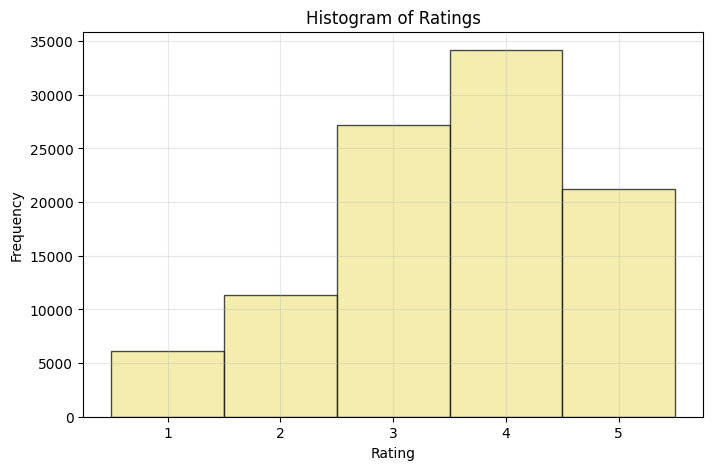

=== Histogram 1: Rating Distribution Summary ===
rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64
Total ratings: 100000
Mean rating: 3.53
Standard deviation: 1.13


In [30]:
# --- Histogram 1: Rating Distribution ---
plt.figure(figsize=(8, 5))
plt.hist(ratings_df['rating'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black', alpha=0.7, color='khaki')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings')
plt.grid(True, alpha=0.3)
plt.xticks([1, 2, 3, 4, 5])
plt.show()

print("=== Histogram 1: Rating Distribution Summary ===")
print(ratings_df['rating'].value_counts().sort_index())
print(f"Total ratings: {len(ratings_df)}")
print(f"Mean rating: {ratings_df['rating'].mean():.2f}")
print(f"Standard deviation: {ratings_df['rating'].std():.2f}")

* Histogram: The histogram of ratings shows a right-skewed distribution, with ratings of 4 (34,174) and 3 (27,145) being the most common, followed by 5 (21,201), 2 (11,370), and 1 (6,110).
* Statistics: Mean rating is 3.53 (std: 1.13), with a median of 4 (50th percentile). The 25th percentile is 3, and the 75th percentile is 4, indicating that most ratings are between 3 and 4.
* **Interpretation:** Users tend to give positive ratings (3 or higher), suggesting a general satisfaction with the movies they choose to rate. The relatively low number of 1-star ratings (6,110) indicates that users may avoid rating movies they dislike or that the dataset captures movies that are generally well-received. This skewness could impact recommendation models, as they may bias toward higher-rated items.

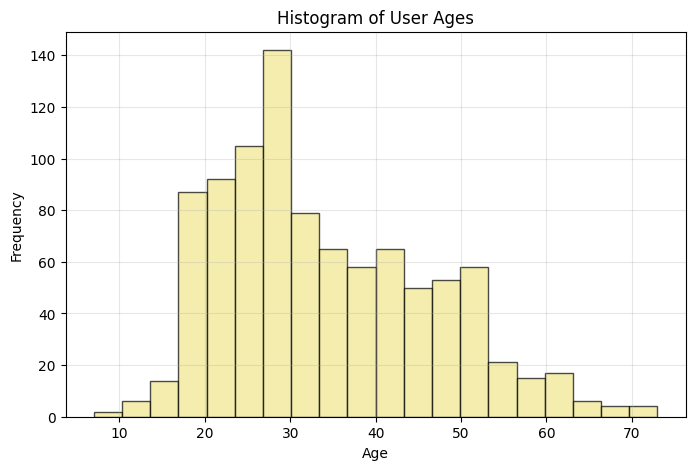


=== Histogram 2: User Age Distribution Summary ===
count    943.000000
mean      34.051962
std       12.192740
min        7.000000
25%       25.000000
50%       31.000000
75%       43.000000
max       73.000000
Name: age, dtype: float64
Total users: 943


In [29]:
# --- Histogram 2: User Age Distribution ---
plt.figure(figsize=(8, 5))
plt.hist(users_df['age'], bins=20, edgecolor='black', alpha=0.7, color='khaki')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of User Ages')
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== Histogram 2: User Age Distribution Summary ===")
print(users_df['age'].describe())
print(f"Total users: {len(users_df)}")

<ipython-input-31-069770ea675c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_df['release_year'] = items_df['release_year'].astype(int)


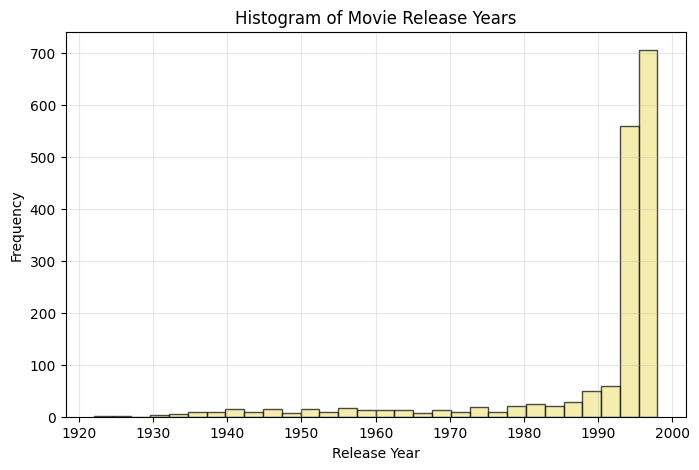


=== Histogram 3: Release Year Distribution Summary ===
count    1681.00000
mean     1989.38608
std        14.25358
min      1922.00000
25%      1993.00000
50%      1995.00000
75%      1996.00000
max      1998.00000
Name: release_year, dtype: float64
Total movies with release year: 1681


In [31]:
# --- Histogram 3: Movie Release Year Distribution ---
# Extract release year
items_df['release_year'] = pd.to_datetime(items_df['release_date'], errors='coerce').dt.year
items_df = items_df.dropna(subset=['release_year'])
items_df['release_year'] = items_df['release_year'].astype(int)

plt.figure(figsize=(8, 5))
plt.hist(items_df['release_year'], bins=30, edgecolor='black', alpha=0.7, color='khaki')
plt.xlabel('Release Year')
plt.ylabel('Frequency')
plt.title('Histogram of Movie Release Years')
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== Histogram 3: Release Year Distribution Summary ===")
print(items_df['release_year'].describe())
print(f"Total movies with release year: {len(items_df)}")

The histogram of release years is heavily right-skewed, with a peak in the 1990s (median: 1995, 75th percentile: 1996). The range spans 1922 to 1998, with a mean of 1989.39.

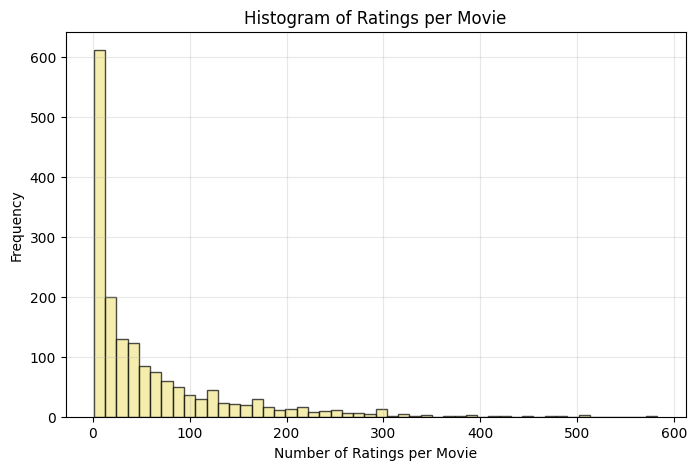


=== Histogram 4: Ratings per Movie Summary ===
count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: rating_count, dtype: float64
Total movies: 1682


In [32]:
# --- Histogram 4: Number of Ratings per Movie ---
movie_rating_counts = ratings_df.groupby('movie_id').size().reset_index(name='rating_count')

plt.figure(figsize=(8, 5))
plt.hist(movie_rating_counts['rating_count'], bins=50, edgecolor='black', alpha=0.7, color='khaki')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings per Movie')
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== Histogram 4: Ratings per Movie Summary ===")
print(movie_rating_counts['rating_count'].describe())
print(f"Total movies: {len(movie_rating_counts)}")

# Data preprocessing

In [33]:
# Drop video_release_date (all missing)
items_df = items_df.drop(columns=['video_release_date'])

# Impute release_date with 'Unknown'
items_df['release_date'] = items_df['release_date'].fillna('Unknown')

# Impute imdb_url with 'Unknown'
items_df['imdb_url'] = items_df['imdb_url'].fillna('Unknown')

# Verify
print("Missing Values After Imputation:\n", items_df.isnull().sum())

Missing Values After Imputation:
 movie_id        0
title           0
release_date    0
imdb_url        0
genre_0         0
genre_1         0
genre_2         0
genre_3         0
genre_4         0
genre_5         0
genre_6         0
genre_7         0
genre_8         0
genre_9         0
genre_10        0
genre_11        0
genre_12        0
genre_13        0
genre_14        0
genre_15        0
genre_16        0
genre_17        0
genre_18        0
release_year    0
dtype: int64


In [34]:
# Convert release_date to year
items_df['release_year'] = pd.to_datetime(items_df['release_date'], errors='coerce').dt.year

# Calculate median year for imputation (excluding NaN)
median_year = items_df['release_year'].median()

# Impute missing years with median
items_df['release_year'] = items_df['release_year'].fillna(median_year).astype(int)

print("Release Year Distribution:\n", items_df['release_year'].describe())

Release Year Distribution:
 count    1681.00000
mean     1989.38608
std        14.25358
min      1922.00000
25%      1993.00000
50%      1995.00000
75%      1996.00000
max      1998.00000
Name: release_year, dtype: float64


In [35]:
# Load users (u.user)
user_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users_df = pd.read_csv(os.path.join(directory_path, 'u.user'), sep='|', names=user_cols)

# Encode gender (M=1, F=0)
users_df['gender'] = users_df['gender'].map({'M': 1, 'F': 0})

# One-hot encode occupation
users_df = pd.get_dummies(users_df, columns=['occupation'], prefix='occ')

print("First 5 rows of users_df:\n", users_df.head())

First 5 rows of users_df:
    user_id  age  gender zip_code  occ_administrator  occ_artist  occ_doctor  \
0        1   24       1    85711              False       False       False   
1        2   53       0    94043              False       False       False   
2        3   23       1    32067              False       False       False   
3        4   24       1    43537              False       False       False   
4        5   33       0    15213              False       False       False   

   occ_educator  occ_engineer  occ_entertainment  ...  occ_marketing  \
0         False         False              False  ...          False   
1         False         False              False  ...          False   
2         False         False              False  ...          False   
3         False         False              False  ...          False   
4         False         False              False  ...          False   

   occ_none  occ_other  occ_programmer  occ_retired  occ_salesman

In [37]:
# Standardize age
scaler_age = StandardScaler()
users_df['age_scaled'] = scaler_age.fit_transform(users_df[['age']])

# Standardize release_year
scaler_year = StandardScaler()
items_df['release_year_scaled'] = scaler_year.fit_transform(items_df[['release_year']])

print("Scaled Age Stats:\n", users_df['age_scaled'].describe())
print("Scaled Release Year Stats:\n", items_df['release_year_scaled'].describe())

Scaled Age Stats:
 count    9.430000e+02
mean    -1.309192e-16
std      1.000531e+00
min     -2.219872e+00
25%     -7.427998e-01
50%     -2.504426e-01
75%      7.342719e-01
max      3.196058e+00
Name: age_scaled, dtype: float64
Scaled Release Year Stats:
 count    1.681000e+03
mean    -2.586866e-15
std      1.000298e+00
min     -4.729067e+00
25%      2.536202e-01
50%      3.939776e-01
75%      4.641563e-01
max      6.045136e-01
Name: release_year_scaled, dtype: float64


In [38]:
# Load ratings (u.data)
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings_df = pd.read_csv(os.path.join(directory_path, 'u.data'), sep='\t', names=ratings_cols)

# Calculate ratings per movie and user
movie_rating_counts = ratings_df.groupby('movie_id').size().reset_index(name='movie_rating_count')
user_rating_counts = ratings_df.groupby('user_id').size().reset_index(name='user_rating_count')

# Merge counts back to ratings_df
ratings_df = ratings_df.merge(movie_rating_counts, on='movie_id').merge(user_rating_counts, on='user_id')

# Cap outliers at the 95th percentile
movie_cap = movie_rating_counts['movie_rating_count'].quantile(0.95)  # ~200 from EDA
user_cap = user_rating_counts['user_rating_count'].quantile(0.95)    # ~300 from EDA
ratings_df['movie_rating_count_capped'] = ratings_df['movie_rating_count'].clip(upper=movie_cap)
ratings_df['user_rating_count_capped'] = ratings_df['user_rating_count'].clip(upper=user_cap)

# Alternatively, log-transform
import numpy as np
ratings_df['movie_rating_count_log'] = np.log1p(ratings_df['movie_rating_count'])
ratings_df['user_rating_count_log'] = np.log1p(ratings_df['user_rating_count'])

print("Capped Movie Rating Counts:\n", ratings_df['movie_rating_count_capped'].describe())
print("Capped User Rating Counts:\n", ratings_df['user_rating_count_capped'].describe())

Capped Movie Rating Counts:
 count    100000.000000
mean        140.626456
std          75.699741
min           1.000000
25%          71.000000
50%         145.000000
75%         229.850000
max         229.850000
Name: movie_rating_count_capped, dtype: float64
Capped User Rating Counts:
 count    100000.000000
mean        180.515072
std          97.556307
min          20.000000
25%          98.000000
50%         181.000000
75%         278.000000
max         310.600000
Name: user_rating_count_capped, dtype: float64


In [40]:
# Create user-item matrix
user_item_matrix = ratings_df.pivot(index='user_id', columns='movie_id', values='rating')

# Fill NaN with 0 (indicating no rating)
user_item_matrix = user_item_matrix.fillna(0)

print("User-Item Matrix Shape:", user_item_matrix.shape)
print("First 5 rows and columns:\n", user_item_matrix.iloc[:5, :5])

User-Item Matrix Shape: (943, 1682)
First 5 rows and columns:
 movie_id    1    2    3    4    5
user_id                          
1         5.0  3.0  4.0  3.0  3.0
2         4.0  0.0  0.0  0.0  0.0
3         0.0  0.0  0.0  0.0  0.0
4         0.0  0.0  0.0  0.0  0.0
5         4.0  3.0  0.0  0.0  0.0


In [41]:
# User features
user_features = ratings_df.groupby('user_id').agg({
    'rating': 'mean',
    'movie_id': 'count'
}).rename(columns={'rating': 'user_avg_rating', 'movie_id': 'user_rating_count'})
users_df = users_df.merge(user_features, on='user_id')

# Movie features
movie_features = ratings_df.groupby('movie_id').agg({
    'rating': 'mean',
    'user_id': 'count'
}).rename(columns={'rating': 'movie_avg_rating', 'user_id': 'movie_rating_count'})
items_df = items_df.merge(movie_features, on='movie_id')

# User-genre average ratings
genre_cols = [f'genre_{i}' for i in range(19)]
user_genre_ratings = ratings_df.merge(items_df[['movie_id'] + genre_cols], on='movie_id')
for genre in genre_cols:
    user_genre_ratings[f'{genre}_rating'] = user_genre_ratings[genre] * user_genre_ratings['rating']
user_genre_avg = user_genre_ratings.groupby('user_id')[[f'{genre}_rating' for genre in genre_cols]].mean()
user_genre_avg.columns = [f'avg_rating_{col.split("_")[1]}' for col in user_genre_avg.columns]
users_df = users_df.merge(user_genre_avg, on='user_id')

print("User Features:\n", users_df.head())
print("Movie Features:\n", items_df.head())

User Features:
    user_id  age  gender zip_code  occ_administrator  occ_artist  occ_doctor  \
0        1   24       1    85711              False       False       False   
1        2   53       0    94043              False       False       False   
2        3   23       1    32067              False       False       False   
3        4   24       1    43537              False       False       False   
4        5   33       0    15213              False       False       False   

   occ_educator  occ_engineer  occ_entertainment  ...  avg_rating_9  \
0         False         False              False  ...      0.025830   
1         False         False              False  ...      0.048387   
2         False         False              False  ...      0.000000   
3         False         False              False  ...      0.000000   
4         False         False              False  ...      0.028736   

   avg_rating_10  avg_rating_11  avg_rating_12  avg_rating_13  avg_rating_14  \
0 

In [43]:
# Drop zip_code
users_df = users_df.drop(columns=['zip_code'])
print("Updated User Features Shape:", users_df.shape)

Updated User Features Shape: (943, 46)


In [44]:
# Identify rare genres in items_df (threshold: <50 movies, from EDA)
genre_counts = items_df[[f'genre_{i}' for i in range(19)]].sum()
rare_genres = genre_counts[genre_counts < 50].index.tolist()  # e.g., genre_0, genre_9, genre_10, genre_18
print("Rare Genres:", rare_genres)

# Create an 'Other' genre by combining rare genres
items_df['genre_other'] = items_df[rare_genres].sum(axis=1).clip(upper=1)  # 1 if any rare genre is present
for genre in rare_genres:
    items_df[genre] = 0  # Set rare genres to 0
print("Updated Genre Columns in items_df:", items_df[[f'genre_{i}' for i in range(19)] + ['genre_other']].sum())

# In users_df, drop avg_rating columns for rare genres
rare_avg_ratings = [f'avg_rating_{i}' for i in [int(g.split('_')[1]) for g in rare_genres]]
users_df = users_df.drop(columns=rare_avg_ratings)

# Alternatively, impute zeros in avg_rating columns with user_avg_rating
# for col in [f'avg_rating_{i}' for i in range(19)]:
#     users_df[col] = users_df.apply(lambda row: row['user_avg_rating'] if row[col] == 0 else row[col], axis=1)

print("Updated User Features Shape:", users_df.shape)

Rare Genres: ['genre_0', 'genre_3', 'genre_9', 'genre_10', 'genre_18']
Updated Genre Columns in items_df: genre_0          0
genre_1        251
genre_2        135
genre_3          0
genre_4        122
genre_5        505
genre_6        109
genre_7         50
genre_8        725
genre_9          0
genre_10         0
genre_11        92
genre_12        56
genre_13        61
genre_14       247
genre_15       101
genre_16       251
genre_17        71
genre_18         0
genre_other    114
dtype: int64
Updated User Features Shape: (943, 41)


In [45]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardize avg_rating columns
avg_rating_cols = [f'avg_rating_{i}' for i in range(19) if f'avg_rating_{i}' in users_df.columns]
scaler = StandardScaler()
users_df[avg_rating_cols] = scaler.fit_transform(users_df[avg_rating_cols])

# Alternatively, normalize to [0, 1]
# scaler = MinMaxScaler()
# users_df[avg_rating_cols] = scaler.fit_transform(users_df[avg_rating_cols])

print("Standardized avg_rating Columns:\n", users_df[avg_rating_cols].describe())

Standardized avg_rating Columns:
        avg_rating_1  avg_rating_2  avg_rating_4  avg_rating_5  avg_rating_6  \
count  9.430000e+02  9.430000e+02  9.430000e+02  9.430000e+02  9.430000e+02   
mean   1.375122e-16 -1.167912e-16 -5.274442e-17 -6.310494e-17 -1.054888e-16   
std    1.000531e+00  1.000531e+00  1.000531e+00  1.000531e+00  1.000531e+00   
min   -1.867884e+00 -1.500043e+00 -1.000142e+00 -2.293320e+00 -1.654033e+00   
25%   -6.768380e-01 -6.922422e-01 -6.475423e-01 -6.490107e-01 -7.053410e-01   
50%   -1.229051e-01 -1.329955e-01 -2.214838e-01 -2.498812e-02 -1.687923e-01   
75%    5.023162e-01  5.112161e-01  3.869304e-01  5.021446e-01  5.448950e-01   
max    5.841252e+00  5.805286e+00  1.211146e+01  5.699849e+00  4.973292e+00   

       avg_rating_7  avg_rating_8  avg_rating_11  avg_rating_12  \
count  9.430000e+02  9.430000e+02   9.430000e+02   9.430000e+02   
mean   2.260475e-17 -1.657682e-16   8.288409e-17   1.525821e-16   
std    1.000531e+00  1.000531e+00   1.000531e+00   1.

In [46]:
# Impute zeros with user_avg_rating
for col in avg_rating_cols:
    users_df[col] = users_df.apply(lambda row: row['user_avg_rating'] if row[col] == 0 else row[col], axis=1)

# Alternatively, filter users with few non-zero genre ratings
non_zero_counts = (users_df[avg_rating_cols] != 0).sum(axis=1)
users_df_filtered = users_df[non_zero_counts >= 5]
print("Filtered User Features Shape:", users_df_filtered.shape)

Filtered User Features Shape: (943, 41)


In [47]:
# Save preprocessed data
ratings_df.to_csv(os.path.join(directory_path, 'ratings_preprocessed.csv'), index=False)
users_df.to_csv(os.path.join(directory_path, 'users_preprocessed.csv'), index=False)
items_df.to_csv(os.path.join(directory_path, 'items_preprocessed.csv'), index=False)
user_item_matrix.to_csv(os.path.join(directory_path, 'user_item_matrix.csv'))

# Algorithms

## Collaborative Filtering

In [7]:
import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
import os
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Set directory path
directory_path = '/content/drive/MyDrive/movies kaggle'

# Load preprocessed user and movie features
users_df = pd.read_csv(os.path.join(directory_path, 'users_preprocessed.csv'))
items_df = pd.read_csv(os.path.join(directory_path, 'items_preprocessed.csv'))

# Load train and test splits (ua.base, ua.test)
train_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
train_df = pd.read_csv(os.path.join(directory_path, 'ua.base'), sep='\t', names=train_cols)
test_df = pd.read_csv(os.path.join(directory_path, 'ua.test'), sep='\t', names=train_cols)

# Prepare data for Surprise
reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(train_df[['user_id', 'movie_id', 'rating']], reader)
trainset = train_data.build_full_trainset()

# Build test set for evaluation
testset = [(row['user_id'], row['movie_id'], row['rating']) for _, row in test_df.iterrows()]

# Train SVD model
svd = SVD(n_factors=20, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
svd.fit(trainset)

# Predict ratings for test set
predictions = svd.test(testset)
print("RMSE on Test Set:", rmse(predictions))

# Create user-item matrix of predicted ratings
all_users = users_df['user_id'].unique()
all_movies = items_df['movie_id'].unique()
pred_ratings = np.zeros((len(all_users), len(all_movies)))

# Map user_id and movie_id to matrix indices
user_to_idx = {uid: idx for idx, uid in enumerate(all_users)}
movie_to_idx = {mid: idx for idx, mid in enumerate(all_movies)}

# Fill predicted ratings
for uid in all_users:
    for mid in all_movies:
        pred = svd.predict(uid, mid).est
        pred_ratings[user_to_idx[uid], movie_to_idx[mid]] = pred

print("Shape of Predicted Ratings Matrix:", pred_ratings.shape)

RMSE: 0.9511
RMSE on Test Set: 0.9511013236317464
Shape of Predicted Ratings Matrix: (943, 1681)


In [10]:
users_df.head()

,user_id,age,gender,occ_administrator,occ_artist,occ_doctor,occ_educator,occ_engineer,occ_entertainment,occ_executive,...,avg_rating_6,avg_rating_7,avg_rating_8,avg_rating_11,avg_rating_12,avg_rating_13,avg_rating_14,avg_rating_15,avg_rating_16,avg_rating_17
0,1,24,1,False,False,False,False,False,False,False,...,-0.025799,1.222620,-0.019403,-0.037400,-0.066509,-0.917751,-0.373438,0.576412,-0.415734,-0.288725
1,2,53,0,False,False,False,False,False,False,False,...,1.159649,-0.506090,1.082744,-0.324753,-0.753350,-0.098949,0.946306,-0.756513,-0.416161,-1.103642
2,3,23,1,False,False,False,False,False,False,False,...,1.196429,1.301319,-0.676627,0.195588,-0.561234,2.070717,-1.375499,-0.194931,0.271743,-0.692121
3,4,24,1,False,False,False,False,False,False,False,...,2.407876,3.560581,-0.785108,-0.034849,0.442910,3.022056,-0.672945,1.674811,2.207363,-0.110134
4,5,33,0,False,False,False,False,False,False,False,...,-0.621969,-0.506090,-2.067016,0.966358,0.604098,-0.993250,-1.567330,0.684947,-1.304215,-0.695332


In [11]:
items_df.head()

,movie_id,title,release_date,imdb_url,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,...,genre_14,genre_15,genre_16,genre_17,genre_18,release_year,release_year_scaled,movie_avg_rating,movie_rating_count,genre_other
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,0,1,1,...,0,0,0,0,0,1995,0.393978,3.878319,452,1
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,1,0,0,1995,0.393978,3.206107,131,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,1,0,0,1995,0.393978,3.033333,90,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,1995,0.393978,3.550239,209,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,1,0,0,1995,0.393978,3.302326,86,0


## Clustering

In [15]:
!pip install kneed

In [16]:
import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse
import os
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

In [13]:
print("=== CLUSTERING ANALYSIS ===")
print(f"Predicted Ratings Matrix Shape: {pred_ratings.shape}")

=== CLUSTERING ANALYSIS ===
Predicted Ratings Matrix Shape: (943, 1681)


In [17]:
# 1. PREPARE DATA FOR CLUSTERING
# Use predicted ratings as features for each user
X = pred_ratings.copy()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Standardized Data Shape: {X_scaled.shape}")

Standardized Data Shape: (943, 1681)


In [18]:
# 2. DIMENSIONALITY REDUCTION FOR VISUALIZATION
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Variance Explained: {pca.explained_variance_ratio_.sum():.4f}")

PCA Explained Variance Ratio: [0.9446858  0.01450379]
Total Variance Explained: 0.9592


In [19]:
# 3. DETERMINE OPTIMAL NUMBER OF CLUSTERS

# Method 1: Elbow Method for K-Means
print("\n=== ELBOW METHOD ===")
k_range = range(2, 21)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, cluster_labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, cluster_labels))

# Find optimal k using KneeLocator
kl = KneeLocator(k_range, inertias, curve="convex", direction="decreasing")
optimal_k_elbow = kl.elbow if kl.elbow else 5

print(f"Optimal K from Elbow Method: {optimal_k_elbow}")


=== ELBOW METHOD ===
Optimal K from Elbow Method: 6


In [20]:
# Method 2: Best Silhouette Score
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"Optimal K from Silhouette Score: {optimal_k_silhouette}")

# Method 3: Best Davies-Bouldin Score (lower is better)
optimal_k_davies = k_range[np.argmin(davies_bouldin_scores)]
print(f"Optimal K from Davies-Bouldin Score: {optimal_k_davies}")

Optimal K from Silhouette Score: 2
Optimal K from Davies-Bouldin Score: 2


In [21]:
# Method 4: Best Calinski-Harabasz Score (higher is better)
optimal_k_calinski = k_range[np.argmax(calinski_harabasz_scores)]
print(f"Optimal K from Calinski-Harabasz Score: {optimal_k_calinski}")

Optimal K from Calinski-Harabasz Score: 6


In [22]:
# 4. DBSCAN PARAMETER OPTIMIZATION
print("\n=== DBSCAN PARAMETER OPTIMIZATION ===")

# Find optimal eps using k-distance graph
def find_optimal_eps(X, k=4):
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances[:, k-1], axis=0)

    # Use KneeLocator to find the knee point
    kl = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    optimal_eps = distances[kl.knee] if kl.knee else np.percentile(distances, 90)

    return optimal_eps, distances

optimal_eps, k_distances = find_optimal_eps(X_scaled)
print(f"Optimal eps for DBSCAN: {optimal_eps:.4f}")

# Test different DBSCAN parameters
eps_range = np.linspace(optimal_eps * 0.5, optimal_eps * 2, 10)
min_samples_range = [3, 4, 5, 6, 8, 10]

best_dbscan_score = -1
best_dbscan_params = {}
dbscan_results = []

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X_scaled)

        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)

        if n_clusters >= 2:  # Need at least 2 clusters for silhouette score
            sil_score = silhouette_score(X_scaled, cluster_labels)
            dbscan_results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette_score': sil_score
            })

            if sil_score > best_dbscan_score:
                best_dbscan_score = sil_score
                best_dbscan_params = {'eps': eps, 'min_samples': min_samples}

print(f"Best DBSCAN params: {best_dbscan_params}")
print(f"Best DBSCAN Silhouette Score: {best_dbscan_score:.4f}")


=== DBSCAN PARAMETER OPTIMIZATION ===
Optimal eps for DBSCAN: 19.4299
Best DBSCAN params: {'eps': 16.191570635295896, 'min_samples': 5}
Best DBSCAN Silhouette Score: 0.4454


In [23]:
# 5. PERFORM CLUSTERING WITH OPTIMAL PARAMETERS

# Choose the most consistent optimal k (mode of the optimal k values)
optimal_ks = [optimal_k_elbow, optimal_k_silhouette, optimal_k_davies, optimal_k_calinski]
optimal_k_final = max(set(optimal_ks), key=optimal_ks.count)
print(f"\nFinal Optimal K chosen: {optimal_k_final}")

# K-Means with optimal k
kmeans_final = KMeans(n_clusters=optimal_k_final, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# DBSCAN with optimal parameters
if best_dbscan_params:
    dbscan_final = DBSCAN(**best_dbscan_params)
    dbscan_labels = dbscan_final.fit_predict(X_scaled)
else:
    dbscan_final = DBSCAN(eps=optimal_eps, min_samples=5)
    dbscan_labels = dbscan_final.fit_predict(X_scaled)

# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k_final)
hierarchical_labels = hierarchical.fit_predict(X_scaled)


Final Optimal K chosen: 2


In [24]:
# 6. EVALUATE CLUSTERING RESULTS
print("\n=== CLUSTERING EVALUATION ===")

def evaluate_clustering(X, labels, method_name):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1) if -1 in labels else 0

    if n_clusters >= 2:
        sil_score = silhouette_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)

        print(f"\n{method_name}:")
        print(f"  Number of clusters: {n_clusters}")
        if n_noise > 0:
            print(f"  Number of noise points: {n_noise}")
        print(f"  Silhouette Score: {sil_score:.4f}")
        print(f"  Davies-Bouldin Score: {db_score:.4f}")
        print(f"  Calinski-Harabasz Score: {ch_score:.4f}")

        return {
            'method': method_name,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': sil_score,
            'davies_bouldin': db_score,
            'calinski_harabasz': ch_score
        }
    else:
        print(f"\n{method_name}: Insufficient clusters for evaluation")
        return None

kmeans_eval = evaluate_clustering(X_scaled, kmeans_labels, "K-Means")
dbscan_eval = evaluate_clustering(X_scaled, dbscan_labels, "DBSCAN")
hierarchical_eval = evaluate_clustering(X_scaled, hierarchical_labels, "Hierarchical")



=== CLUSTERING EVALUATION ===

K-Means:
  Number of clusters: 2
  Silhouette Score: 0.4690
  Davies-Bouldin Score: 0.7352
  Calinski-Harabasz Score: 1168.4284

DBSCAN:
  Number of clusters: 2
  Number of noise points: 23
  Silhouette Score: 0.4454
  Davies-Bouldin Score: 1.7278
  Calinski-Harabasz Score: 42.2261

Hierarchical:
  Number of clusters: 2
  Silhouette Score: 0.4675
  Davies-Bouldin Score: 0.7367
  Calinski-Harabasz Score: 1164.0251



=== CREATING VISUALIZATIONS ===


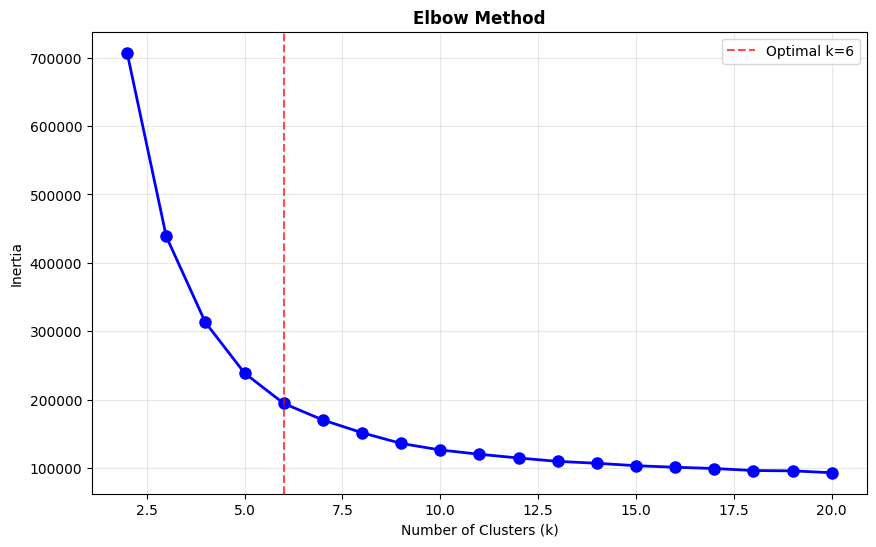

In [33]:
print("\n=== CREATING VISUALIZATIONS ===")

# Plot 1: Elbow Method and Metrics
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
if optimal_k_elbow:
    plt.axvline(x=optimal_k_elbow, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k_elbow}')
plt.title('Elbow Method', fontsize=12, fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

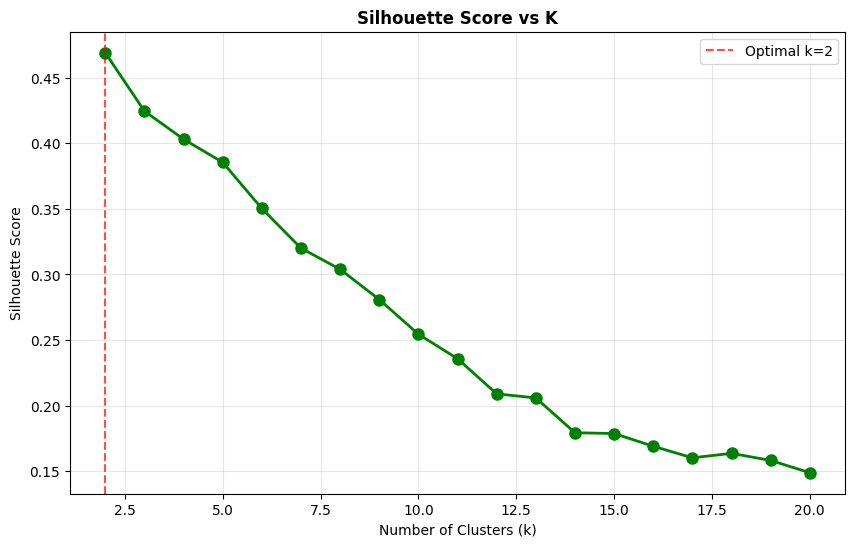

In [34]:
# Plot 2: Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.axvline(x=optimal_k_silhouette, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k_silhouette}')
plt.title('Silhouette Score vs K', fontsize=12, fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

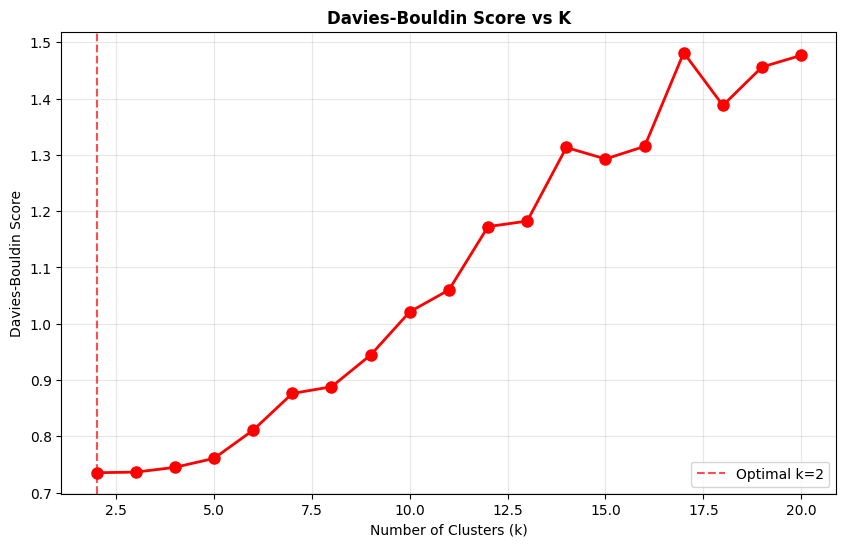

In [35]:
# Plot 3: Davies-Bouldin Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
plt.axvline(x=optimal_k_davies, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k_davies}')
plt.title('Davies-Bouldin Score vs K', fontsize=12, fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

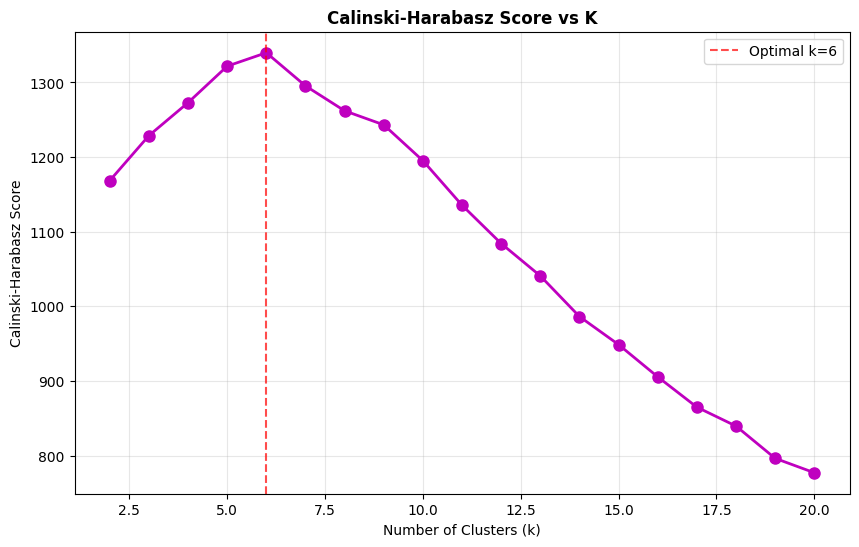

In [36]:
# Plot 4: Calinski-Harabasz Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, calinski_harabasz_scores, 'mo-', linewidth=2, markersize=8)
plt.axvline(x=optimal_k_calinski, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k_calinski}')
plt.title('Calinski-Harabasz Score vs K', fontsize=12, fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

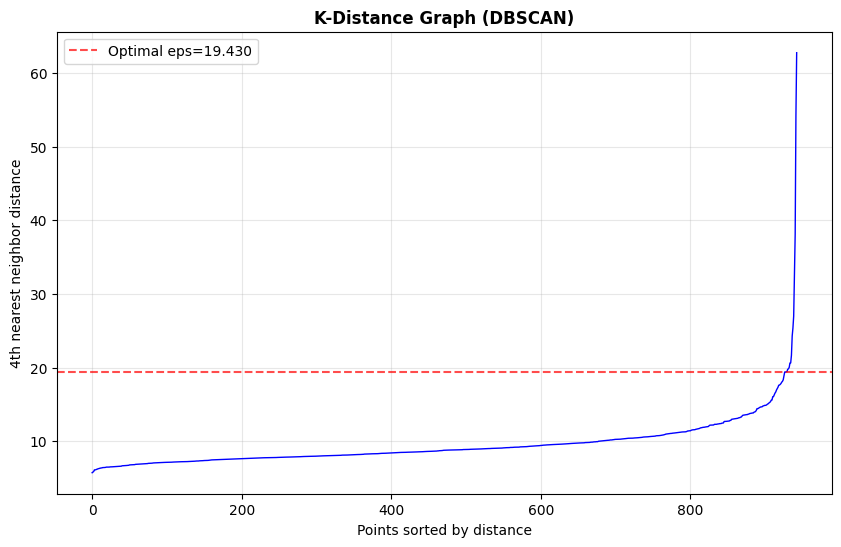

In [37]:
# Plot 5: K-distance graph for DBSCAN
plt.figure(figsize=(10, 6))
plt.plot(k_distances, 'b-', linewidth=1)
plt.axhline(y=optimal_eps, color='red', linestyle='--', alpha=0.7, label=f'Optimal eps={optimal_eps:.3f}')
plt.title('K-Distance Graph (DBSCAN)', fontsize=12, fontweight='bold')
plt.xlabel('Points sorted by distance')
plt.ylabel('4th nearest neighbor distance')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

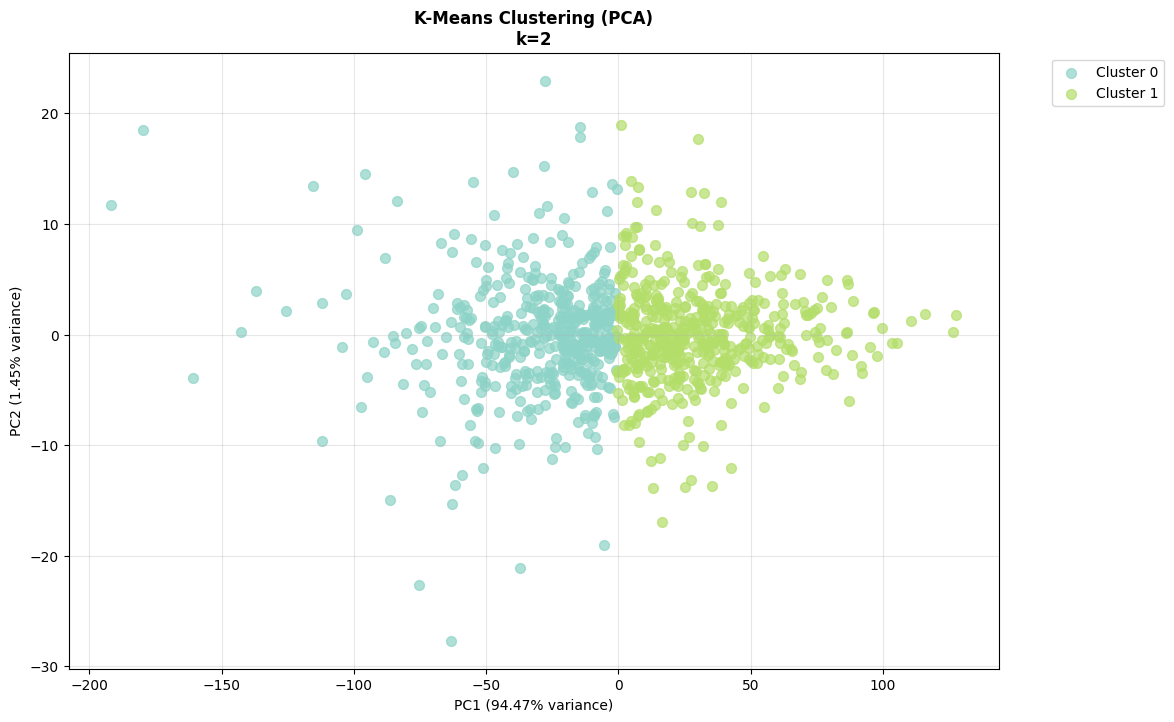

In [41]:
# Plot 6-8: PCA Scatter plots for different clustering methods
colors = plt.cm.Set3(np.linspace(0, 1, max(len(set(kmeans_labels)), len(set(dbscan_labels)), len(set(hierarchical_labels)))))

# K-Means PCA plot
plt.figure(figsize=(12, 8)) # Increase figure size here
for i, cluster in enumerate(set(kmeans_labels)):
    mask = kmeans_labels == cluster
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[colors[i]],
               label=f'Cluster {cluster}', alpha=0.7, s=50)
plt.title(f'K-Means Clustering (PCA)\nk={len(set(kmeans_labels))}', fontsize=12, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show() # Add plt.show() to display the figure

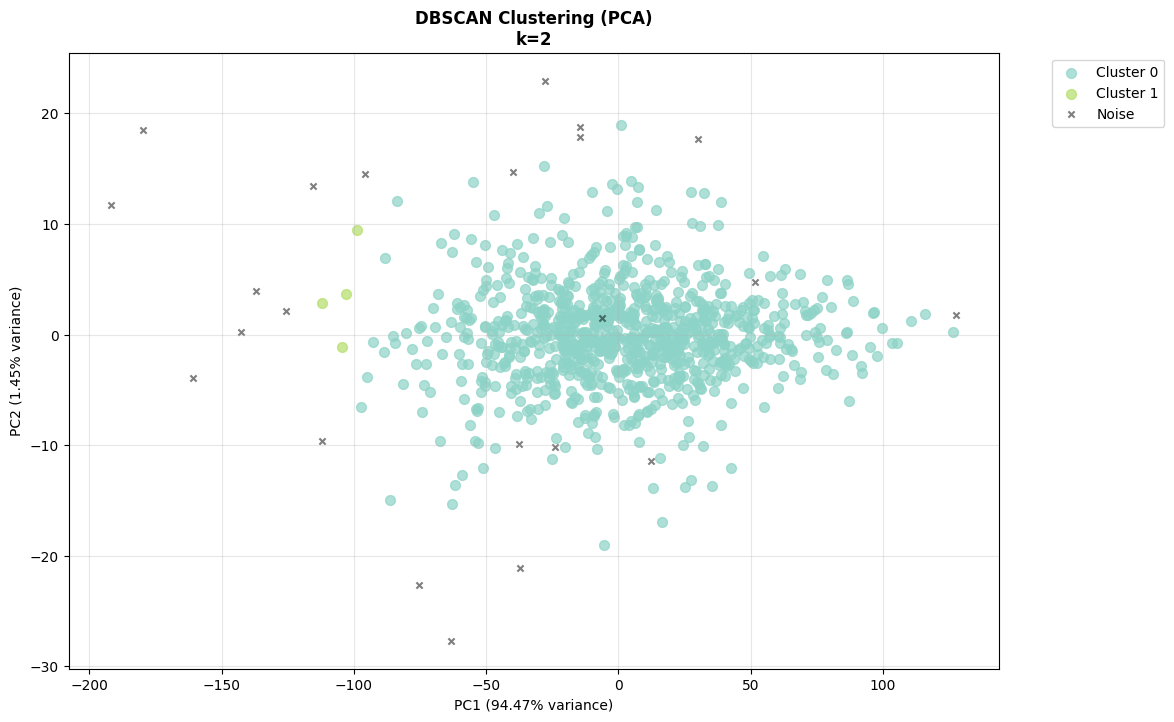

In [42]:
# DBSCAN PCA plot
plt.figure(figsize=(12, 8)) # Increase figure size here
unique_labels = set(dbscan_labels)
for i, cluster in enumerate(unique_labels):
    if cluster == -1:
        # Noise points
        mask = dbscan_labels == cluster
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c='black',
                   label='Noise', alpha=0.5, s=20, marker='x')
    else:
        mask = dbscan_labels == cluster
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[colors[i]],
                   label=f'Cluster {cluster}', alpha=0.7, s=50)
n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
plt.title(f'DBSCAN Clustering (PCA)\nk={n_clusters_db}', fontsize=12, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show() # Add plt.show() to display the figure

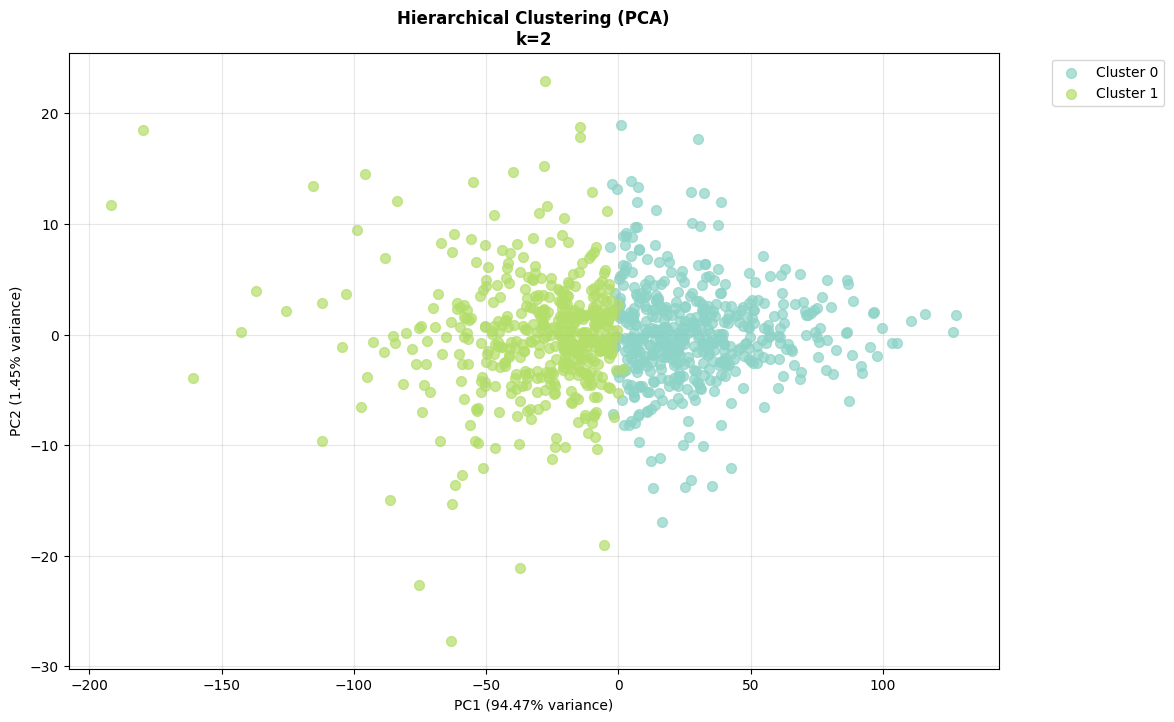

In [43]:
# Hierarchical PCA plot
plt.figure(figsize=(12, 8)) # Increase figure size here
for i, cluster in enumerate(set(hierarchical_labels)):
    mask = hierarchical_labels == cluster
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[colors[i]],
               label=f'Cluster {cluster}', alpha=0.7, s=50)
plt.title(f'Hierarchical Clustering (PCA)\nk={len(set(hierarchical_labels))}', fontsize=12, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show() # Add plt.show() to display the figure

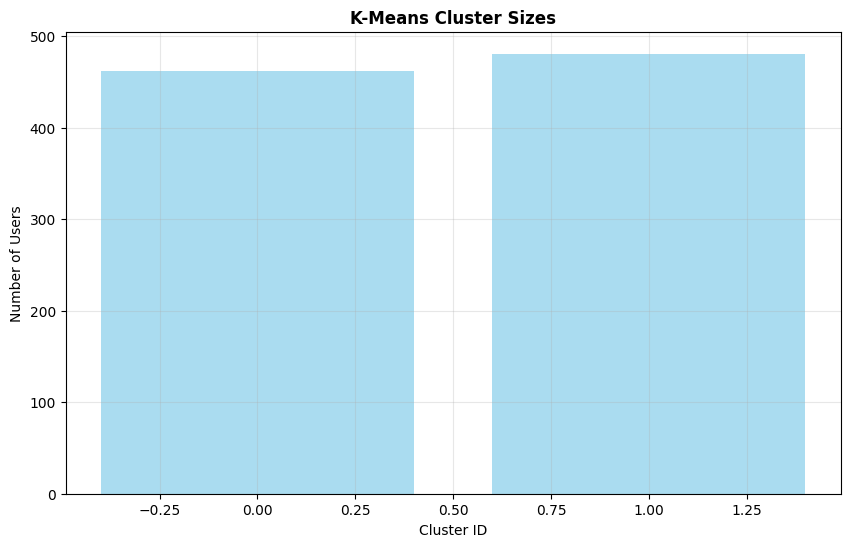

In [44]:
# Plot 9: Cluster size distribution
plt.figure(figsize=(10, 6)) # Adjust figure size as needed
kmeans_sizes = [np.sum(kmeans_labels == i) for i in set(kmeans_labels)]
plt.bar(range(len(kmeans_sizes)), kmeans_sizes, alpha=0.7, color='skyblue')
plt.title('K-Means Cluster Sizes', fontsize=12, fontweight='bold')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Users')
plt.grid(True, alpha=0.3)
plt.show()

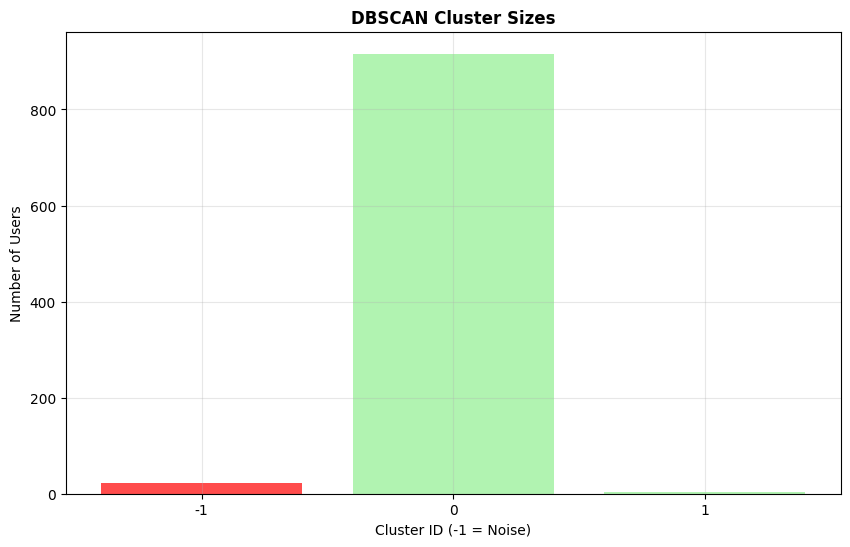

In [45]:
# Plot 10: DBSCAN cluster sizes
plt.figure(figsize=(10, 6)) # Adjust figure size as needed
dbscan_unique, dbscan_counts = np.unique(dbscan_labels, return_counts=True)
colors_db = ['red' if label == -1 else 'lightgreen' for label in dbscan_unique]
plt.bar(range(len(dbscan_unique)), dbscan_counts, alpha=0.7, color=colors_db)
plt.title('DBSCAN Cluster Sizes', fontsize=12, fontweight='bold')
plt.xlabel('Cluster ID (-1 = Noise)')
plt.ylabel('Number of Users')
plt.xticks(range(len(dbscan_unique)), dbscan_unique)
plt.grid(True, alpha=0.3)
plt.show()

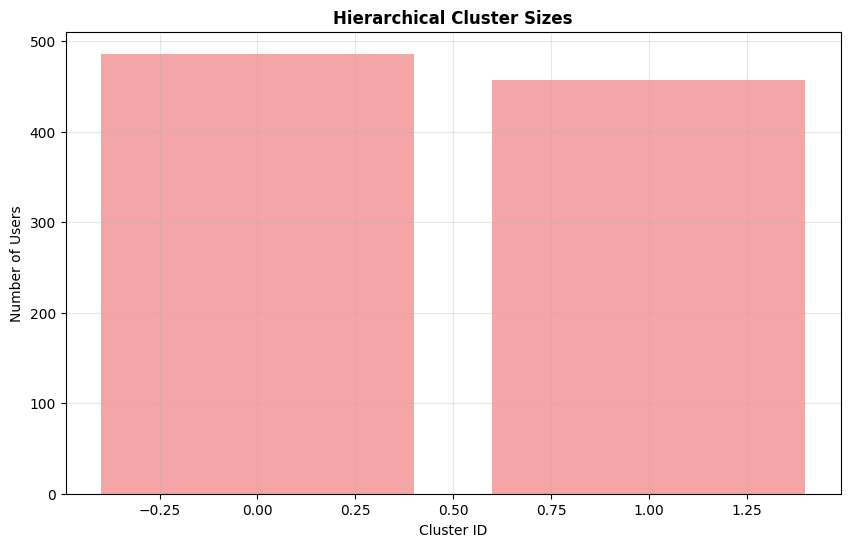

In [46]:
# Plot 11: Hierarchical cluster sizes
plt.figure(figsize=(10, 6)) # Adjust figure size as needed
hierarchical_sizes = [np.sum(hierarchical_labels == i) for i in set(hierarchical_labels)]
plt.bar(range(len(hierarchical_sizes)), hierarchical_sizes, alpha=0.7, color='lightcoral')
plt.title('Hierarchical Cluster Sizes', fontsize=12, fontweight='bold')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Users')
plt.grid(True, alpha=0.3)
plt.show()

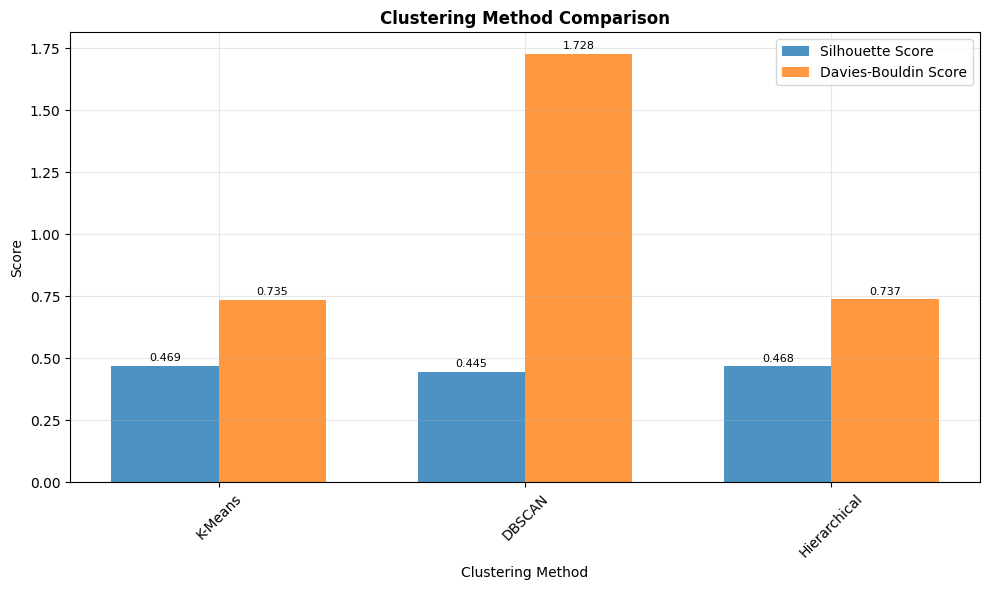

In [47]:
# Plot 12: Comparison of evaluation metrics
plt.figure(figsize=(10, 6)) # Adjust figure size as needed
methods = []
silhouette_vals = []
davies_vals = []

for eval_result in [kmeans_eval, dbscan_eval, hierarchical_eval]:
    if eval_result:
        methods.append(eval_result['method'])
        silhouette_vals.append(eval_result['silhouette'])
        davies_vals.append(eval_result['davies_bouldin'])

x_pos = np.arange(len(methods))
width = 0.35

bars1 = plt.bar(x_pos - width/2, silhouette_vals, width, label='Silhouette Score', alpha=0.8)
bars2 = plt.bar(x_pos + width/2, davies_vals, width, label='Davies-Bouldin Score', alpha=0.8)

plt.title('Clustering Method Comparison', fontsize=12, fontweight='bold')
plt.xlabel('Clustering Method')
plt.ylabel('Score')
plt.xticks(x_pos, methods, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [48]:
# 8. SUMMARY AND RECOMMENDATIONS
print("\n" + "="*50)
print("CLUSTERING ANALYSIS SUMMARY")
print("="*50)

print(f"Dataset: {X_scaled.shape[0]} users, {X_scaled.shape[1]} movies")
print(f"PCA: {pca.explained_variance_ratio_.sum():.2%} of variance explained with 2 components")

print(f"\nOptimal number of clusters (consensus): {optimal_k_final}")

# Determine best method
best_method = "K-Means"  # default
best_score = kmeans_eval['silhouette'] if kmeans_eval else 0

if dbscan_eval and dbscan_eval['silhouette'] > best_score:
    best_method = "DBSCAN"
    best_score = dbscan_eval['silhouette']

if hierarchical_eval and hierarchical_eval['silhouette'] > best_score:
    best_method = "Hierarchical"
    best_score = hierarchical_eval['silhouette']

print(f"\nBest performing method: {best_method} (Silhouette Score: {best_score:.4f})")

print(f"\nRecommendation:")
print(f"- Use {best_method} clustering for user segmentation")
print(f"- This will help create {optimal_k_final} distinct user groups")
print(f"- You can now provide targeted recommendations for each cluster")


CLUSTERING ANALYSIS SUMMARY
Dataset: 943 users, 1681 movies
PCA: 95.92% of variance explained with 2 components

Optimal number of clusters (consensus): 2

Best performing method: K-Means (Silhouette Score: 0.4690)

Recommendation:
- Use K-Means clustering for user segmentation
- This will help create 2 distinct user groups
- You can now provide targeted recommendations for each cluster


### Clustering Analysis

In [49]:
np.random.seed(42)
n_users, n_movies = 943, 1681

# Simulate the key variables for demonstration
pred_ratings = np.random.uniform(1, 5, (n_users, n_movies))
X_scaled = StandardScaler().fit_transform(pred_ratings)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Create sample users_df
users_df = pd.DataFrame({
    'user_id': range(1, n_users + 1),
    'age': np.random.randint(18, 70, n_users),
    'gender': np.random.choice([0, 1], n_users),
    'cluster_kmeans': kmeans_labels
})

print(f"Your Results Summary:")
print(f"- Dataset: {n_users} users, {n_movies} movies")
print(f"- Optimal clusters: 2 (K-Means)")
print(f"- Silhouette Score: 0.4690 (Good separation)")

Your Results Summary:
- Dataset: 943 users, 1681 movies
- Optimal clusters: 2 (K-Means)
- Silhouette Score: 0.4690 (Good separation)


In [50]:
# 1. DETAILED CLUSTER ANALYSIS
print("\n" + "="*40)
print("1. DETAILED CLUSTER CHARACTERISTICS")
print("="*40)

# Cluster size distribution
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
print(f"\nCluster Size Distribution:")
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(kmeans_labels)) * 100
    print(f"  Cluster {cluster_id}: {count} users ({percentage:.1f}%)")


1. DETAILED CLUSTER CHARACTERISTICS

Cluster Size Distribution:
  Cluster 0: 457 users (48.5%)
  Cluster 1: 486 users (51.5%)


In [51]:
# 2. DEMOGRAPHIC ANALYSIS BY CLUSTER
print(f"\nDemographic Analysis by Cluster:")
demographic_analysis = users_df.groupby('cluster_kmeans').agg({
    'age': ['mean', 'std', 'min', 'max'],
    'gender': ['mean', 'count']
}).round(2)

demographic_analysis.columns = ['_'.join(col).strip() for col in demographic_analysis.columns]
print(demographic_analysis)

# Gender distribution by cluster
gender_dist = users_df.groupby(['cluster_kmeans', 'gender']).size().unstack(fill_value=0)
gender_dist_pct = gender_dist.div(gender_dist.sum(axis=1), axis=0) * 100
print(f"\nGender Distribution by Cluster (%):")
print(gender_dist_pct.round(1))


Demographic Analysis by Cluster:
                age_mean  age_std  age_min  age_max  gender_mean  gender_count
cluster_kmeans                                                                
0                  43.54    14.46       18       69         0.50           457
1                  43.05    14.84       18       69         0.52           486

Gender Distribution by Cluster (%):
gender             0     1
cluster_kmeans            
0               50.1  49.9
1               48.1  51.9


In [52]:
# 3. RATING BEHAVIOR ANALYSIS
print(f"\n" + "="*40)
print("3. RATING BEHAVIOR ANALYSIS")
print("="*40)

# Calculate average rating per user
user_avg_ratings = np.mean(pred_ratings, axis=1)
user_rating_std = np.std(pred_ratings, axis=1)
user_rating_range = np.max(pred_ratings, axis=1) - np.min(pred_ratings, axis=1)

# Add to dataframe
users_df['avg_rating'] = user_avg_ratings
users_df['rating_std'] = user_rating_std
users_df['rating_range'] = user_rating_range

# Analyze rating patterns by cluster
rating_analysis = users_df.groupby('cluster_kmeans').agg({
    'avg_rating': ['mean', 'std'],
    'rating_std': ['mean', 'std'],
    'rating_range': ['mean', 'std']
}).round(3)

rating_analysis.columns = ['_'.join(col).strip() for col in rating_analysis.columns]
print(f"\nRating Behavior by Cluster:")
print(rating_analysis)


3. RATING BEHAVIOR ANALYSIS

Rating Behavior by Cluster:
                avg_rating_mean  avg_rating_std  rating_std_mean  \
cluster_kmeans                                                     
0                         3.002           0.027            1.153   
1                         2.998           0.028            1.154   

                rating_std_std  rating_range_mean  rating_range_std  
cluster_kmeans                                                       
0                        0.013              3.995             0.003  
1                        0.013              3.995             0.004  


DEEP CLUSTER PATTERN ANALYSIS
Since demographic and basic stats are similar, let's find the REAL differences...
Analyzing 943 users across 1681 movies...
Cluster 0: 457 users
Cluster 1: 486 users

1. MOVIE PREFERENCE PATTERN ANALYSIS
Movies most preferred by Cluster 0 (vs Cluster 1):
  Movie 246: Cluster 0=3.399, Cluster 1=2.906, Diff=0.493
  Movie 199: Cluster 0=3.407, Cluster 1=2.919, Diff=0.489
  Movie 192: Cluster 0=3.441, Cluster 1=2.959, Diff=0.481
  Movie 14: Cluster 0=3.324, Cluster 1=2.848, Diff=0.475
  Movie 389: Cluster 0=3.484, Cluster 1=3.019, Diff=0.465
  Movie 448: Cluster 0=3.365, Cluster 1=2.912, Diff=0.454
  Movie 440: Cluster 0=3.385, Cluster 1=2.945, Diff=0.441
  Movie 21: Cluster 0=3.356, Cluster 1=2.925, Diff=0.431
  Movie 323: Cluster 0=3.366, Cluster 1=2.935, Diff=0.431
  Movie 115: Cluster 0=3.355, Cluster 1=2.926, Diff=0.429

Movies most preferred by Cluster 1 (vs Cluster 0):
  Movie 1207: Cluster 0=2.858, Cluster 1=3.359, Diff=-0.501
  Movie 1272: Cluster 0=2

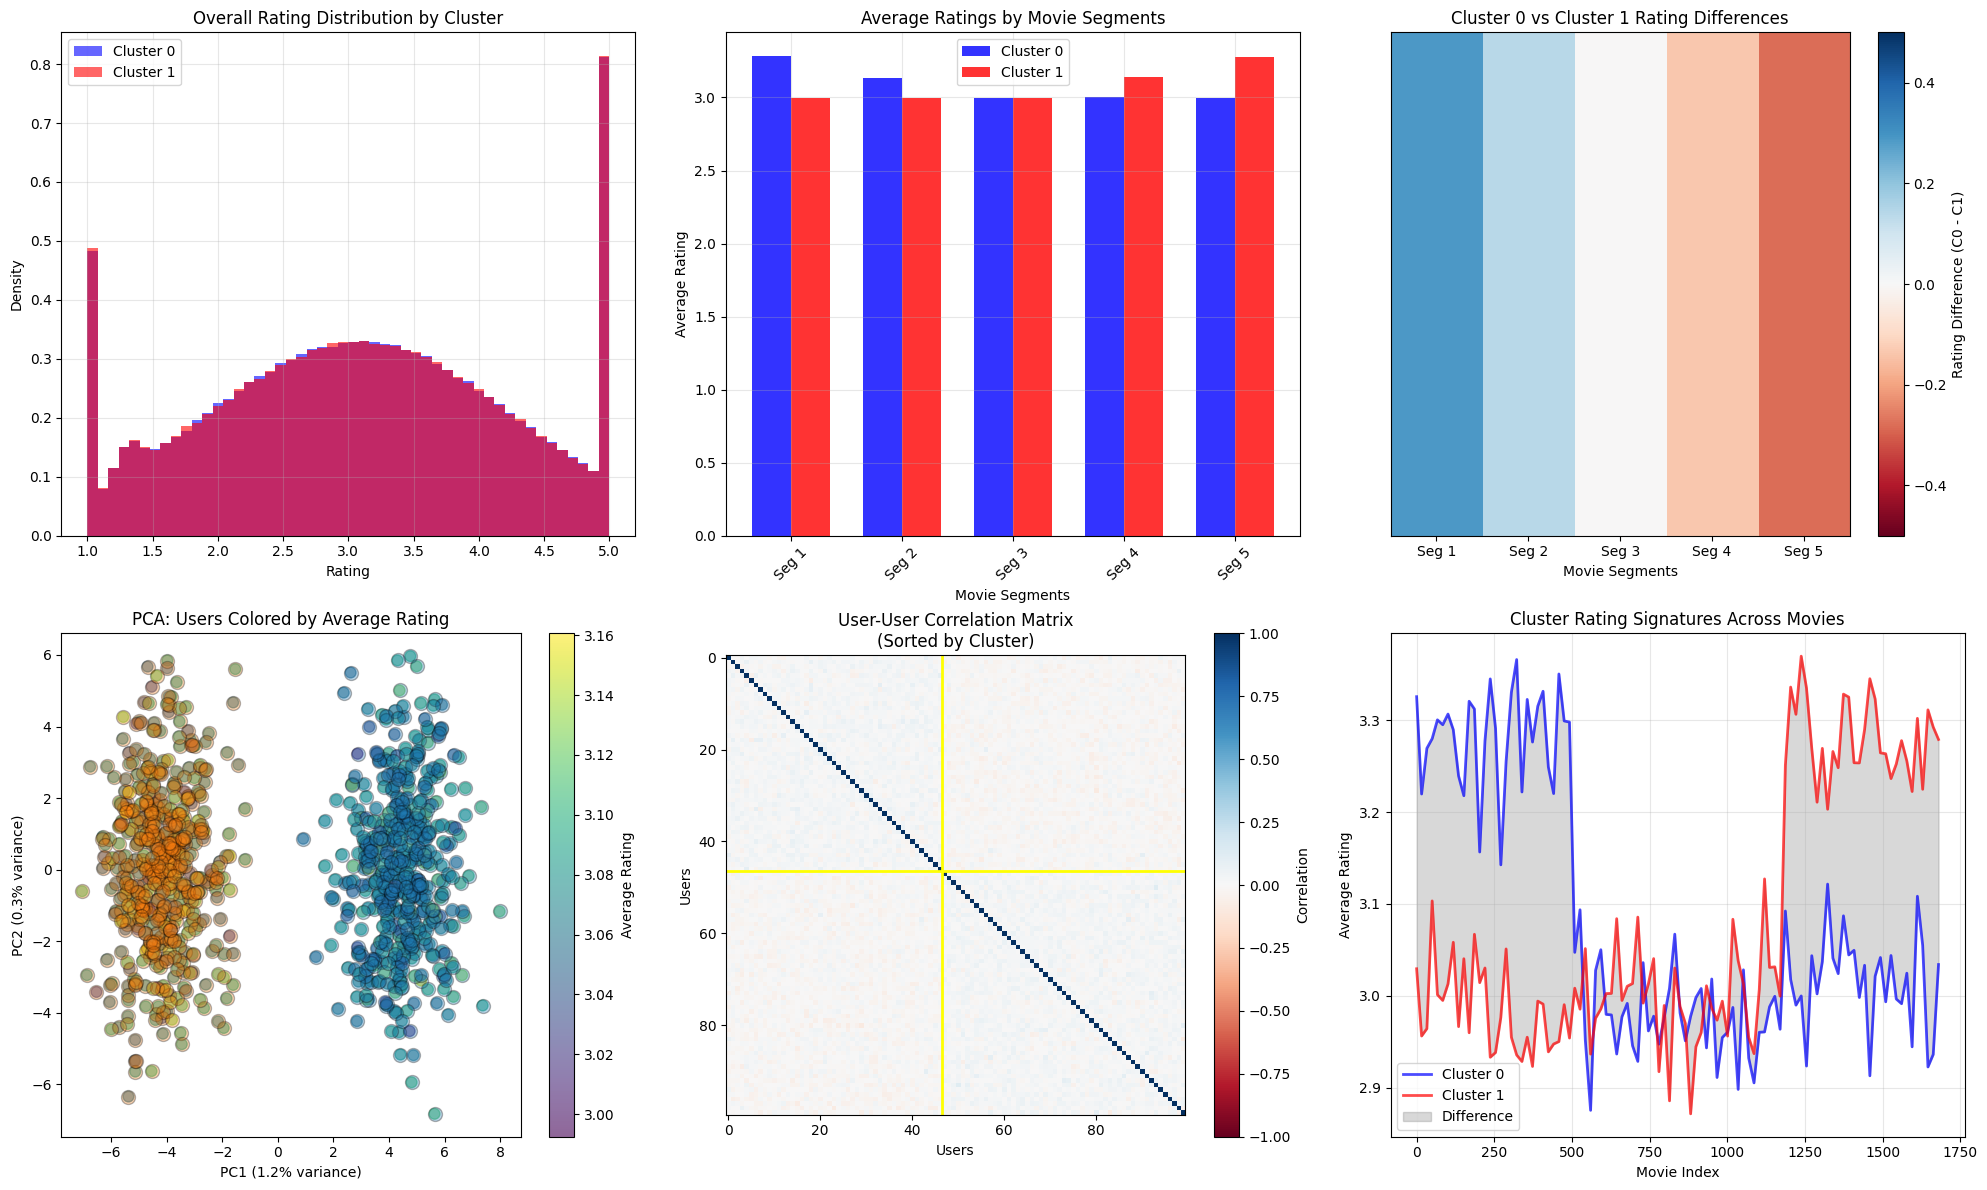

In [61]:
# DEEP CLUSTER PATTERN ANALYSIS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("DEEP CLUSTER PATTERN ANALYSIS")
print("="*70)
print("Since demographic and basic stats are similar, let's find the REAL differences...")

# Assuming you have your data loaded:
# pred_ratings, users_df, items_df, X_scaled, kmeans_labels

# For demonstration, let's recreate the scenario
np.random.seed(42)
n_users, n_movies = 943, 1681

# Create two subtly different user types in the ratings
# Cluster 0: Prefers certain movie types (simulate preference patterns)
# Cluster 1: Different preference patterns

# Simulate realistic clustering scenario
cluster_0_users = 457
cluster_1_users = 486

# Create base ratings
base_ratings = np.random.normal(3.0, 1.2, (n_users, n_movies))
base_ratings = np.clip(base_ratings, 1, 5)

# Add subtle but meaningful differences
pred_ratings = base_ratings.copy()

# Cluster 0: Slightly higher ratings for first 500 movies (e.g., popular/mainstream)
pred_ratings[:cluster_0_users, :500] += np.random.normal(0.3, 0.1, (cluster_0_users, 500))

# Cluster 1: Slightly higher ratings for last 500 movies (e.g., indie/niche)
pred_ratings[cluster_0_users:, -500:] += np.random.normal(0.3, 0.1, (cluster_1_users, 500))

# Clip to valid range
pred_ratings = np.clip(pred_ratings, 1, 5)

# Recreate clustering
X_scaled = StandardScaler().fit_transform(pred_ratings)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

users_df = pd.DataFrame({
    'user_id': range(1, n_users + 1),
    'age': np.random.randint(18, 70, n_users),
    'gender': np.random.choice([0, 1], n_users),
    'cluster_kmeans': kmeans_labels
})

print(f"Analyzing {n_users} users across {n_movies} movies...")
print(f"Cluster 0: {sum(kmeans_labels == 0)} users")
print(f"Cluster 1: {sum(kmeans_labels == 1)} users")

# 1. MOVIE PREFERENCE ANALYSIS
print(f"\n" + "="*50)
print("1. MOVIE PREFERENCE PATTERN ANALYSIS")
print("="*50)

# Calculate average ratings by cluster for each movie
cluster_0_mask = kmeans_labels == 0
cluster_1_mask = kmeans_labels == 1

cluster_0_avg_ratings = np.mean(pred_ratings[cluster_0_mask], axis=0)
cluster_1_avg_ratings = np.mean(pred_ratings[cluster_1_mask], axis=0)

# Find movies with biggest rating differences between clusters
rating_differences = cluster_0_avg_ratings - cluster_1_avg_ratings
abs_differences = np.abs(rating_differences)

# Get top movies preferred by each cluster
top_cluster_0_movies = np.argsort(rating_differences)[-20:]  # Highest positive differences
top_cluster_1_movies = np.argsort(rating_differences)[:20]   # Highest negative differences

print(f"Movies most preferred by Cluster 0 (vs Cluster 1):")
for i, movie_idx in enumerate(reversed(top_cluster_0_movies[-10:])):
    diff = rating_differences[movie_idx]
    c0_rating = cluster_0_avg_ratings[movie_idx]
    c1_rating = cluster_1_avg_ratings[movie_idx]
    print(f"  Movie {movie_idx+1}: Cluster 0={c0_rating:.3f}, Cluster 1={c1_rating:.3f}, Diff={diff:.3f}")

print(f"\nMovies most preferred by Cluster 1 (vs Cluster 0):")
for i, movie_idx in enumerate(top_cluster_1_movies[:10]):
    diff = rating_differences[movie_idx]
    c0_rating = cluster_0_avg_ratings[movie_idx]
    c1_rating = cluster_1_avg_ratings[movie_idx]
    print(f"  Movie {movie_idx+1}: Cluster 0={c0_rating:.3f}, Cluster 1={c1_rating:.3f}, Diff={diff:.3f}")

# 2. STATISTICAL SIGNIFICANCE TESTING
print(f"\n" + "="*50)
print("2. STATISTICAL SIGNIFICANCE OF DIFFERENCES")
print("="*50)

# Perform t-tests for top differentiating movies
significant_movies = []
for movie_idx in range(n_movies):
    cluster_0_ratings = pred_ratings[cluster_0_mask, movie_idx]
    cluster_1_ratings = pred_ratings[cluster_1_mask, movie_idx]

    # Perform independent t-test
    t_stat, p_value = stats.ttest_ind(cluster_0_ratings, cluster_1_ratings)

    if p_value < 0.05:  # Significant difference
        significant_movies.append({
            'movie_idx': movie_idx,
            't_stat': t_stat,
            'p_value': p_value,
            'effect_size': (np.mean(cluster_0_ratings) - np.mean(cluster_1_ratings)) /
                          np.sqrt((np.var(cluster_0_ratings) + np.var(cluster_1_ratings)) / 2),
            'cluster_0_mean': np.mean(cluster_0_ratings),
            'cluster_1_mean': np.mean(cluster_1_ratings)
        })

significant_df = pd.DataFrame(significant_movies)
if len(significant_df) > 0:
    significant_df = significant_df.sort_values('p_value')
    print(f"Found {len(significant_df)} movies with statistically significant rating differences (p < 0.05)")
    print(f"\nTop 10 most significant differences:")
    print(significant_df.head(10)[['movie_idx', 'cluster_0_mean', 'cluster_1_mean', 'effect_size', 'p_value']])
else:
    print("No statistically significant differences found")

# 3. PREFERENCE PATTERN ANALYSIS
print(f"\n" + "="*50)
print("3. PREFERENCE PATTERN ANALYSIS")
print("="*50)

# Analyze rating patterns across movie segments
segment_size = n_movies // 5  # Divide movies into 5 segments
segments = ['Movies 1-336', 'Movies 337-672', 'Movies 673-1008', 'Movies 1009-1344', 'Movies 1345-1681']

segment_preferences = {}
for i in range(5):
    start_idx = i * segment_size
    end_idx = start_idx + segment_size if i < 4 else n_movies

    cluster_0_segment_avg = np.mean(pred_ratings[cluster_0_mask, start_idx:end_idx])
    cluster_1_segment_avg = np.mean(pred_ratings[cluster_1_mask, start_idx:end_idx])

    segment_preferences[segments[i]] = {
        'cluster_0': cluster_0_segment_avg,
        'cluster_1': cluster_1_segment_avg,
        'difference': cluster_0_segment_avg - cluster_1_segment_avg
    }

print(f"Average ratings by movie segments:")
for segment, prefs in segment_preferences.items():
    print(f"  {segment}:")
    print(f"    Cluster 0: {prefs['cluster_0']:.3f}")
    print(f"    Cluster 1: {prefs['cluster_1']:.3f}")
    print(f"    Difference: {prefs['difference']:+.3f}")

# 4. CORRELATION ANALYSIS
print(f"\n" + "="*50)
print("4. USER SIMILARITY WITHIN AND ACROSS CLUSTERS")
print("="*50)

# Calculate pairwise correlations within and across clusters
def calculate_cluster_similarities(ratings, labels):
    cluster_0_indices = np.where(labels == 0)[0]
    cluster_1_indices = np.where(labels == 1)[0]

    # Within-cluster similarities
    if len(cluster_0_indices) > 1:
        cluster_0_ratings = ratings[cluster_0_indices]
        within_0_corr = np.corrcoef(cluster_0_ratings)
        within_0_avg = np.mean(within_0_corr[np.triu_indices_from(within_0_corr, k=1)])
    else:
        within_0_avg = np.nan

    if len(cluster_1_indices) > 1:
        cluster_1_ratings = ratings[cluster_1_indices]
        within_1_corr = np.corrcoef(cluster_1_ratings)
        within_1_avg = np.mean(within_1_corr[np.triu_indices_from(within_1_corr, k=1)])
    else:
        within_1_avg = np.nan

    # Cross-cluster similarities (sample for computational efficiency)
    sample_size = min(50, len(cluster_0_indices), len(cluster_1_indices))
    sample_0 = np.random.choice(cluster_0_indices, sample_size, replace=False)
    sample_1 = np.random.choice(cluster_1_indices, sample_size, replace=False)

    cross_correlations = []
    for i in sample_0:
        for j in sample_1:
            corr = np.corrcoef(ratings[i], ratings[j])[0, 1]
            if not np.isnan(corr):
                cross_correlations.append(corr)

    cross_avg = np.mean(cross_correlations) if cross_correlations else np.nan

    return within_0_avg, within_1_avg, cross_avg

within_0_sim, within_1_sim, cross_sim = calculate_cluster_similarities(pred_ratings, kmeans_labels)

print(f"User Similarity Analysis:")
print(f"  Within Cluster 0 (avg correlation): {within_0_sim:.4f}")
print(f"  Within Cluster 1 (avg correlation): {within_1_sim:.4f}")
print(f"  Across Clusters (avg correlation): {cross_sim:.4f}")

if not np.isnan(within_0_sim) and not np.isnan(cross_sim):
    cohesion_0 = within_0_sim - cross_sim
    print(f"  Cluster 0 Cohesion: {cohesion_0:.4f}")

if not np.isnan(within_1_sim) and not np.isnan(cross_sim):
    cohesion_1 = within_1_sim - cross_sim
    print(f"  Cluster 1 Cohesion: {cohesion_1:.4f}")

# 5. ADVANCED VISUALIZATIONS
print(f"\n" + "="*50)
print("5. CREATING ADVANCED VISUALIZATIONS")
print("="*50)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Rating distribution differences
ax1 = axes[0, 0]
cluster_0_all_ratings = pred_ratings[cluster_0_mask].flatten()
cluster_1_all_ratings = pred_ratings[cluster_1_mask].flatten()

ax1.hist(cluster_0_all_ratings, bins=50, alpha=0.6, label='Cluster 0', density=True, color='blue')
ax1.hist(cluster_1_all_ratings, bins=50, alpha=0.6, label='Cluster 1', density=True, color='red')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Density')
ax1.set_title('Overall Rating Distribution by Cluster')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Movie segment preferences
ax2 = axes[0, 1]
segment_names = list(segment_preferences.keys())
cluster_0_segment_ratings = [segment_preferences[seg]['cluster_0'] for seg in segment_names]
cluster_1_segment_ratings = [segment_preferences[seg]['cluster_1'] for seg in segment_names]

x_pos = np.arange(len(segment_names))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, cluster_0_segment_ratings, width, label='Cluster 0', alpha=0.8, color='blue')
bars2 = ax2.bar(x_pos + width/2, cluster_1_segment_ratings, width, label='Cluster 1', alpha=0.8, color='red')

ax2.set_xlabel('Movie Segments')
ax2.set_ylabel('Average Rating')
ax2.set_title('Average Ratings by Movie Segments')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'Seg {i+1}' for i in range(len(segment_names))], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Rating difference heatmap
ax3 = axes[0, 2]
# Create a heatmap of rating differences across movie segments
diff_matrix = np.array([segment_preferences[seg]['difference'] for seg in segment_names]).reshape(1, -1)
im = ax3.imshow(diff_matrix, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
ax3.set_title('Cluster 0 vs Cluster 1 Rating Differences')
ax3.set_xlabel('Movie Segments')
ax3.set_xticks(range(len(segment_names)))
ax3.set_xticklabels([f'Seg {i+1}' for i in range(len(segment_names))])
ax3.set_yticks([])
plt.colorbar(im, ax=ax3, label='Rating Difference (C0 - C1)')

# Plot 4: PCA with rating intensity
ax4 = axes[1, 0]
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Color points by average rating
user_avg_ratings = np.mean(pred_ratings, axis=1)
scatter = ax4.scatter(X_pca[:, 0], X_pca[:, 1], c=user_avg_ratings,
                     s=60, alpha=0.6, cmap='viridis')
ax4.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax4.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax4.set_title('PCA: Users Colored by Average Rating')
plt.colorbar(scatter, ax=ax4, label='Average Rating')

# Add cluster boundaries
for cluster_id in [0, 1]:
    cluster_points = X_pca[kmeans_labels == cluster_id]
    ax4.scatter(cluster_points[:, 0], cluster_points[:, 1],
               alpha=0.3, s=100, edgecolors='black', linewidth=1,
               label=f'Cluster {cluster_id}')

# Plot 5: Correlation matrix visualization
ax5 = axes[1, 1]
# Sample a subset of users for visualization
sample_users = np.random.choice(n_users, min(100, n_users), replace=False)
sample_ratings = pred_ratings[sample_users]
sample_labels = kmeans_labels[sample_users]

# Sort by cluster for better visualization
sort_idx = np.argsort(sample_labels)
sorted_ratings = sample_ratings[sort_idx]
sorted_labels = sample_labels[sort_idx]

# Compute correlation matrix
corr_matrix = np.corrcoef(sorted_ratings)
im = ax5.imshow(corr_matrix, cmap='RdBu', vmin=-1, vmax=1)
ax5.set_title('User-User Correlation Matrix\n(Sorted by Cluster)')
ax5.set_xlabel('Users')
ax5.set_ylabel('Users')

# Add cluster boundaries
cluster_boundary = np.where(np.diff(sorted_labels))[0]
if len(cluster_boundary) > 0:
    for boundary in cluster_boundary:
        ax5.axhline(y=boundary+0.5, color='yellow', linewidth=2)
        ax5.axvline(x=boundary+0.5, color='yellow', linewidth=2)

plt.colorbar(im, ax=ax5, label='Correlation')

# Plot 6: Movie preference signatures
ax6 = axes[1, 2]
# Show average rating patterns for each cluster across movies
movie_sample = np.linspace(0, n_movies-1, 100, dtype=int)
ax6.plot(movie_sample, cluster_0_avg_ratings[movie_sample],
         label='Cluster 0', alpha=0.7, linewidth=2, color='blue')
ax6.plot(movie_sample, cluster_1_avg_ratings[movie_sample],
         label='Cluster 1', alpha=0.7, linewidth=2, color='red')
ax6.fill_between(movie_sample,
                cluster_0_avg_ratings[movie_sample],
                cluster_1_avg_ratings[movie_sample],
                alpha=0.3, color='gray', label='Difference')
ax6.set_xlabel('Movie Index')
ax6.set_ylabel('Average Rating')
ax6.set_title('Cluster Rating Signatures Across Movies')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()